# Unwarp Lane Images, V1
## Rainer Bareiss

shipping version
apply Lane() with averaging over image frames NOT implemented due to time constraints

30.11.2019

**based on Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  



### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt5

import glob
from IPython.display import Image
from IPython.display import display

import pickle
%matplotlib inline

In [2]:
inputpath = 'camera_cal'
outputpath = 'output_images/'

global outputverbose 
global firstframe

outputverbose= True
fristframe = True

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the following code cell of this IPython notebook.  

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

![alt text][image1]

### Pipeline (single images)



In [10]:
img = mpimg.imread('/home/rainer/dev/37-donkey3/50-hardware/camcal/images_undistort/calimag_flat_center_10mm_to_camera.jpg_undistort.jpg')

#### 1. Provide an example of a distortion-corrected image.

To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:

In [5]:
import os
import numpy as np
import cv2

camera_matrix = np.load(inputpath+"/camera_matrix.npy")
dist_coeffs = np.load(inputpath+"/dist_coeffs.npy")

new_camera_matrix = np.copy(camera_matrix)
new_camera_matrix[:2, :2] /= 2.

print(camera_matrix)
print(dist_coeffs)

print(cv2.__version__)

[[8.21207091e+02 0.00000000e+00 1.56220162e+03]
 [0.00000000e+00 8.20503541e+02 1.23358227e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-0.01592161]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
3.4.1


In [6]:
for jpgname in os.listdir("./images_calibration"):
    print(jpgname)
    if not jpgname.endswith(".jpg"):
        continue
    if "undistort" in jpgname:
        continue
    jpg = cv2.imread(jpgname)
    jpg_undist = cv2.fisheye.undistortImage(jpg, camera_matrix, D=dist_coeffs, Knew=new_camera_matrix)
    #cv2.imshow('img', jpg_undist)
    # cv2.waitKey()

# cv2.destroyAllWindows()
# cv2.waitKey(1)

calimag10.jpg


error: OpenCV(3.4.1) /io/opencv/modules/imgproc/src/imgwarp.cpp:1728: error: (-215) _map1.size().area() > 0 in function remap


The effect of undistorting the image can be seen in the very lower part of the image when looking at the car.

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

I used a combination of color and gradient thresholds to generate a binary image in the following code cell withe the function pipeline.  



In [11]:
# https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
 
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
 
	# return the edged image
	return edged

In [12]:
# 3 Use color transforms, gradients, etc., to create a thresholded binary image.

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    v_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    #sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary #color_binary

Here's an example of my output for this step.  (note: this is not actually from one of the test images)

Step 3: color transforms, gradients to create a thresholded binary image


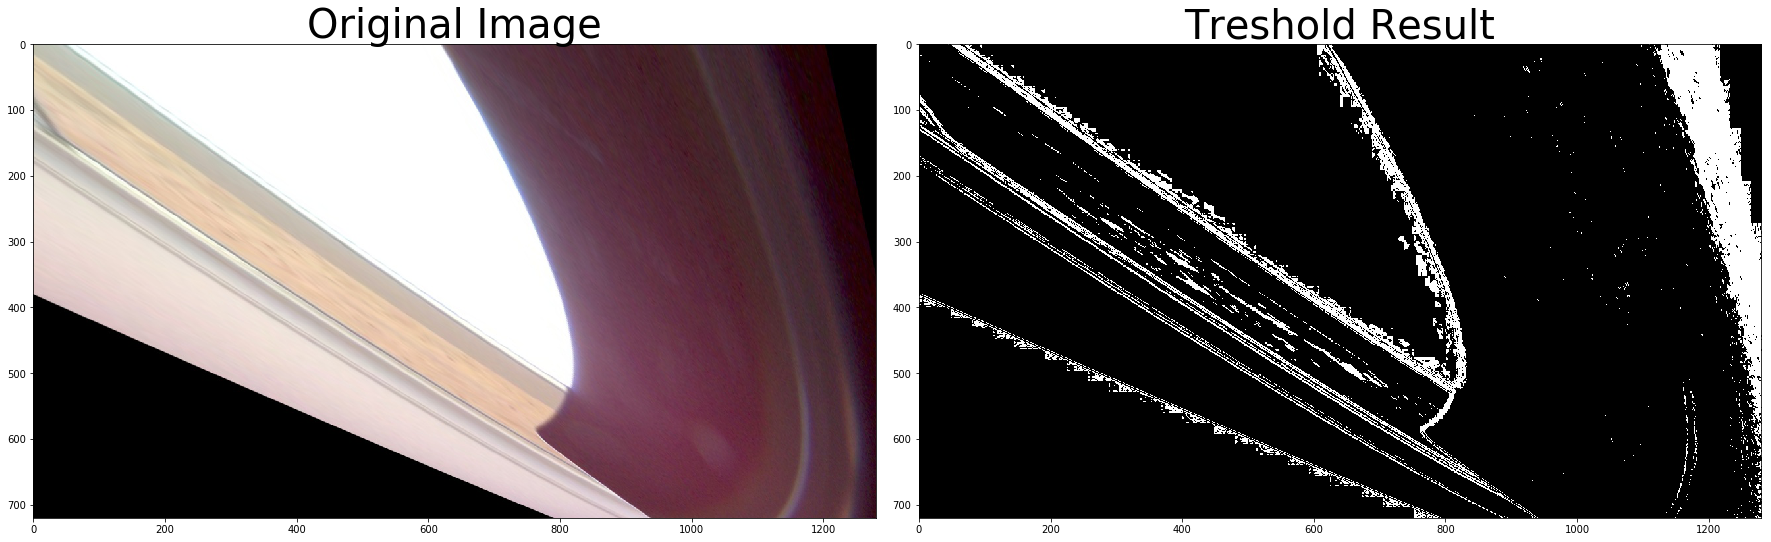

In [13]:
if outputverbose:
    print('Step 3: color transforms, gradients to create a thresholded binary image')

    result = pipeline(img)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(result, cmap='gray')
    ax2.set_title('Treshold Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `warp()`, which appears in the following code cell.  

The `warp()` function takes as inputs an image (`img`).  

I choose to hardcode the source (src) and destination (dst) points in the following manner for a bestfit in the "straight lane image".


| Source        | Destination   | 
|:-------------:|:-------------:| 
| 264, 678      | 253, 686      | 
| 596, 450      | 253, 0        |
| 684, 450      | 1041, 0       |
| 1041, 678     | 1041, 678     |


An alternative approach would have been to use the code from the example writeup:

```python
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
```

In [107]:
# https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
 
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
 
	# return the edged image
	return edged

In [108]:
# 4 Apply a perspective transform to rectify binary image ("birds-eye view").

# define source and destitation points
P_src= []
P_src.append([0  , 120])
P_src.append([160, 120])
P_src.append([ 92,  50])
P_src.append([ 78,  50])
print(P_src)
P_dst= []
P_dst.append([10  ,120])
P_dst.append([150, 120])
P_dst.append([150,   0])
P_dst.append([ 10,   0])
print(P_dst)

def warp(img):
    
    # define calibration box in source (original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])
    print(img_size)
    print(img.shape)
    
    # four source coordinates
    '''
    src = np.float32(
    [[264, 678],
     [596, 450],
     [684, 450],
     [1041, 678]])
    
    # four desired coordinates
    dst = np.float32(
    [[ 253,686],
     [253,0],
     [1041,0],
     [ 1041,678]])
    '''
    #src = np.float32([[0,120],[160, 120],[95,50],[75,50]])    
    #dst = np.float32([[0,120],[160,120],[160,0],[0,  0]])
    '''
    src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    '''
    #M = cv2.getPerspectiveTransform(src, dest)

    #print(dst)
    
    # compute the perspective transform M
    #M = cv2.getPerspectiveTransform(src, dst)
    M = cv2.getPerspectiveTransform(np.float32(P_src), np.float32(P_dst))
    
    # compute the inverse by swapping input parameters
    #Minv = cv2.getPerspectiveTransform(dst, src)
    
    # creat warped image by linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped #, Minv

[[0, 120], [160, 120], [92, 50], [78, 50]]
[[10, 120], [150, 120], [150, 0], [10, 0]]


I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

In [110]:
#print(P_src[0][0],P_src[1][0],P_src[2][0],P_src[3][0])
result = auto_canny(img)

Step 4: perspective transform on ORIGINAL image
(160, 120)
(120, 160, 3)


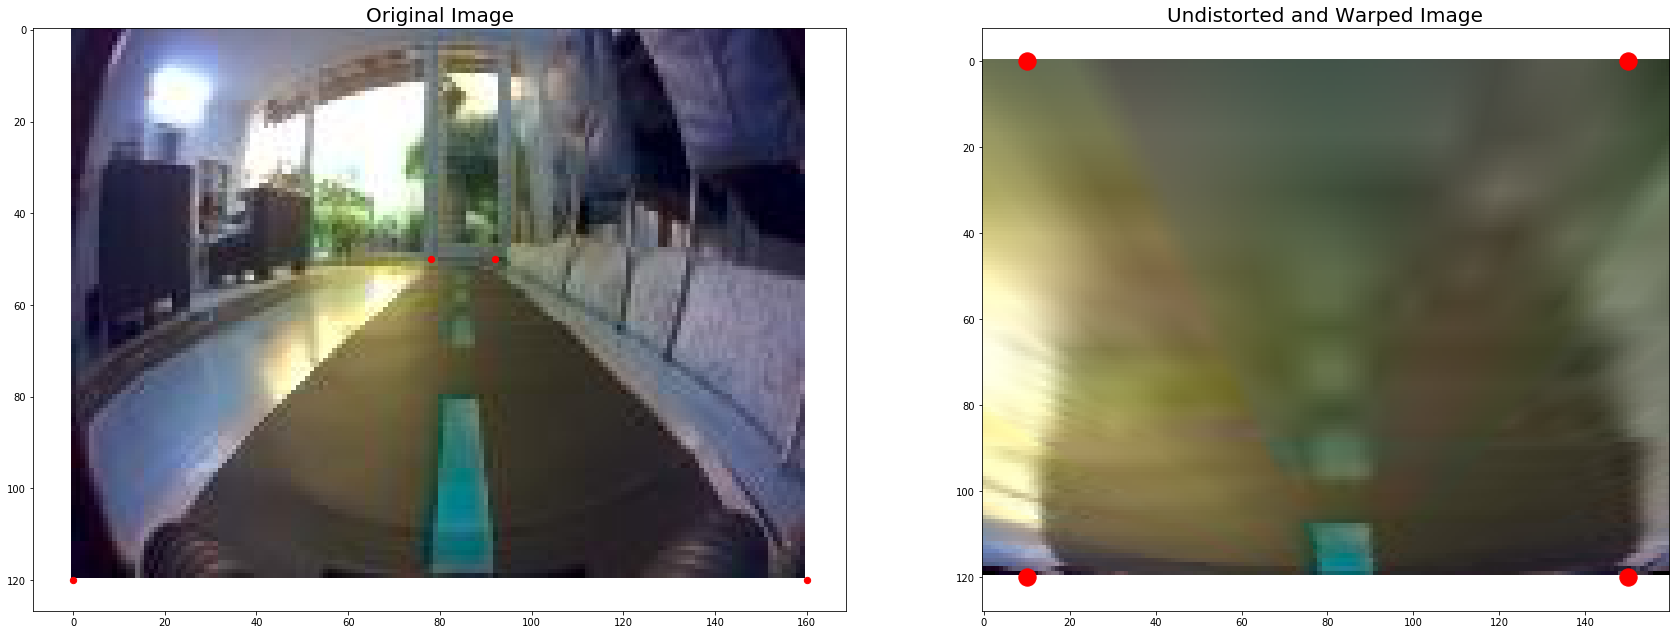

In [111]:
if outputverbose:
    print('Step 4: perspective transform on ORIGINAL image')
    
    ##warped_img = warp(result)
    warped_img = warp(img)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.set_title('Original Image', fontsize=20)
    ax1.imshow(img, cmap='gray')
    #ax1.scatter(x=[0,160,95,75], y=[120,120,50,50],  c='r', s=40)
    ax1.scatter(x=[P_src[0][0],P_src[1][0],P_src[2][0],P_src[3][0]], y= [P_src[0][1],P_src[1][1],P_src[2][1],P_src[3][1]], c='r', s=40)
    
    
    ax2.set_title('Undistorted and Warped Image', fontsize=20)
    ax2.imshow(warped_img, cmap='gray')
    #ax2.scatter(x=[0,160,160,0], y=[120,120,0,0],  c='r', s=300)
    ax2.scatter(x=[P_dst[0][0],P_dst[1][0],P_dst[2][0],P_dst[3][0]], y= [P_dst[0][1],P_dst[1][1],P_dst[2][1],P_dst[3][1]], c='r', s=300)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a TRESHOLDED image and its warped counterpart to verify that the lines appear parallel in the warped image.

Step 4: perspective transform on PIPELINED image
(160, 120)
(120, 160)


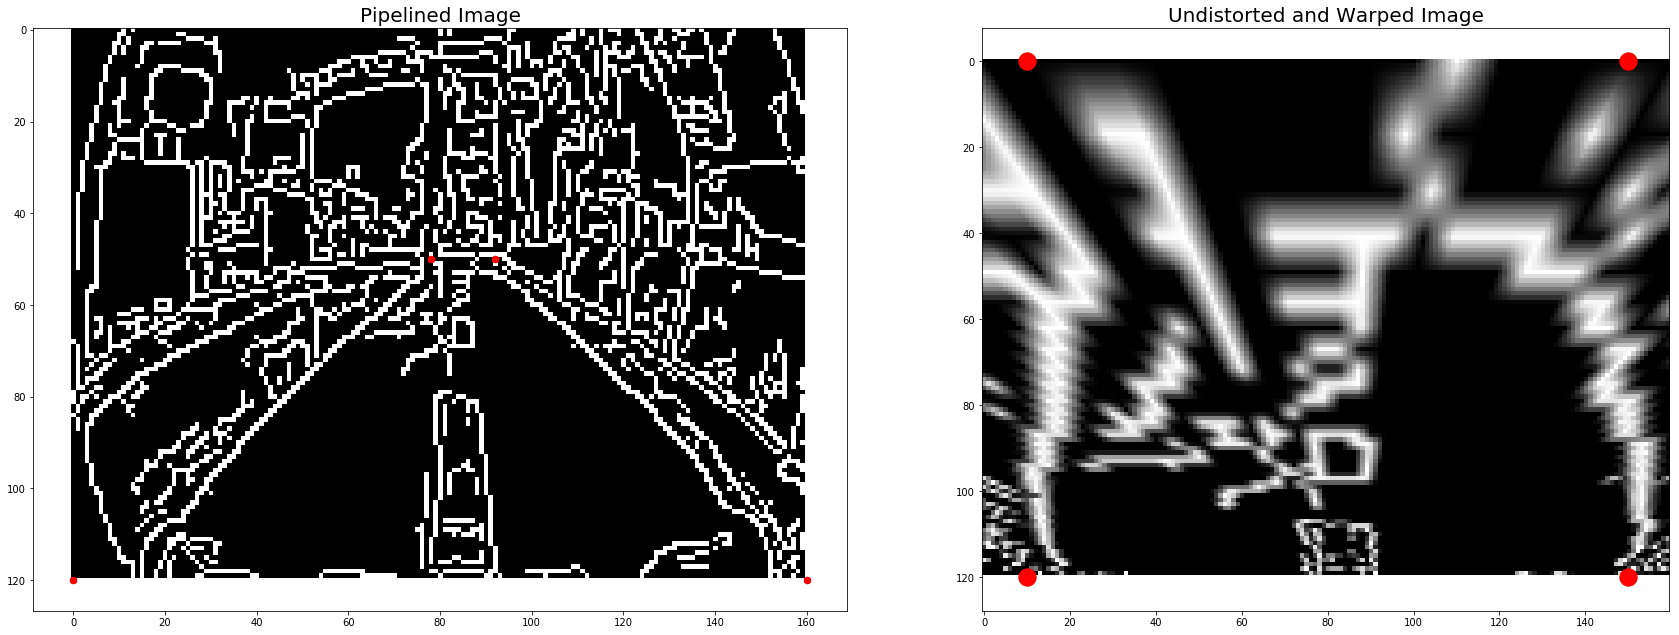

In [112]:
if outputverbose:
    print('Step 4: perspective transform on PIPELINED image')
    
    warped_img = warp(result)
    #warped_img = warp(img)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.set_title('Pipelined Image', fontsize=20)
    ax1.imshow(result, cmap='gray')
    ax1.scatter(x=[P_src[0][0],P_src[1][0],P_src[2][0],P_src[3][0]], y= [P_src[0][1],P_src[1][1],P_src[2][1],P_src[3][1]], c='r', s=40)
    #ax1.scatter(x=[264,596,684,1041], y=[678, 450, 450, 678],  c='r', s=40)
    ax1.scatter(x=[P_src[0][0],P_src[1][0],P_src[2][0],P_src[3][0]], y= [P_src[0][1],P_src[1][1],P_src[2][1],P_src[3][1]], c='r', s=40)

    ax2.set_title('Undistorted and Warped Image', fontsize=20)
    ax2.imshow(warped_img, cmap='gray')
    #ax2.scatter(x=[253, 253, 1041, 1041], y=[686, 0, 0, 686],  c='r', s=300)
    ax2.scatter(x=[P_dst[0][0],P_dst[1][0],P_dst[2][0],P_dst[3][0]], y= [P_dst[0][1],P_dst[1][1],P_dst[2][1],P_dst[3][1]], c='r', s=300)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Then I did some other stuff and fit my lane lines with a 2nd order polynomial kinda like this:

![alt text][image5]



In [113]:
# 5 Detect lane pixels and fit to find the lane boundary.

def detectlane0(binary_warped):

    print("detectlane0: frame no.",leftlane.nframes)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    #histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255 #??????????????
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # store base points
    leftlane.line_base_pos = leftx_base
    rightlane.line_base_pos = rightx_base

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ####### store values in class Line() #######
    
    # set frame counter
    leftlane.nframes += 1
    
    # store current fit coefficents in class Line()
    leftlane.current_fit = left_fit 
    rightlane.current_fit = right_fit 
    
    # set best fit as well
    leftlane.best_fit = left_fit
    rightlane.best_fit = right_fit
    
    # store only current lane points in class Line()
    leftlane.allx = leftx #np.append(leftlane.allx, leftx)
    leftlane.ally = lefty #np.append(leftlane.ally, lefty)
    rightlane.allx = rightx #np.append(rightlane.allx, rightx)
    rightlane.ally = righty #np.append(rightlane.ally, righty)
    
    # Generate x and y values best fit
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # append fitted values to class Line()
    leftlane.recent_xfitted = np.append(leftlane.recent_xfitted, left_fitx)
    rightlane.recent_xfitted = np.append(rightlane.recent_xfitted, right_fitx)
    
    # return coefficents for left & right lane together with pixels indices in "binary_warped" 
    return left_fit, right_fit, left_lane_inds, right_lane_inds, out_img

In [114]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None
        
        # count number of frames
        self.nframes = 0

In [115]:
# generate classes for storing lanes points
rightlane = Line()
leftlane = Line()

The basic idea to identify the lane base points (where it is located at the lower end of the picture)is to take a histogramm of the lower half of the image and take the peaks of left and right lane base point.

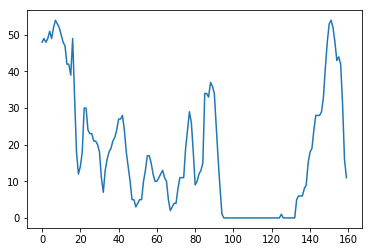

In [116]:
# generate ahistogram of the lower half image
histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
plt.plot(histogram);

A sliding window approach is used to determine the lane points of left and right lane as described in the lecture video and code.

Step 5: detect lane line points
(160, 120)
(120, 160)
detectlane0: frame no. 0
coefficents for left & right lane fit:  [ 7.22413377e-03 -1.49644496e+00  1.13123540e+02] [ 1.21717480e-02 -1.46606927e+00  1.09886667e+02]


NameError: name 'left_fitx' is not defined

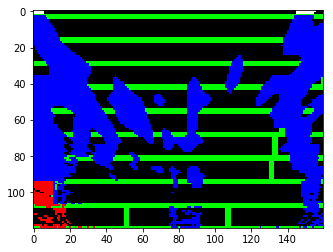

In [117]:
if outputverbose:
    print('Step 5: detect lane line points')
    
    #img = mpimg.imread('test_images/test1.jpg')
    #img = mpimg.imread('test_images/straight_lines1.jpg')
    img = mpimg.imread('1_cam-image_array_.jpg')


    binary_warped = warp(pipeline(img))
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # detect the lane line for first image or after restart
    left_fit, right_fit, left_lane_inds, right_lane_inds, out_img = detectlane0(binary_warped) 
    print("coefficents for left & right lane fit: ",left_fit,right_fit)
    
    # Create an output image to draw on and  visualize the result
    ##out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Generate x and y values for plotting
    ##ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    ##left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    ##right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

In [103]:
# This code has been already prepared for speeding up the code once the lane has been detected

def detectlane1(binary_warped, left_fit, right_fit):

    print("detectlane1: frame no.",leftlane.nframes)
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ####### store values in class Line() #######
    
    leftlane.recent_xfitted = []
    rightlane.recent_xfitted = []
    
    # set frame counter
    leftlane.nframes += 1
    
    # store current fit coefficents in class Line()
    leftlane.current_fit = left_fit 
    rightlane.current_fit = right_fit 
    
    # store only current lane points in class Line()
    leftlane.allx = leftx #np.append(leftlane.allx, leftx)
    leftlane.ally = lefty #np.append(leftlane.ally, lefty)
    rightlane.allx = rightx #np.append(rightlane.allx, rightx)
    rightlane.ally = righty #np.append(rightlane.ally, righty)
    
    # Generate x and y values best fit
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #print("detectlane1: *_fitx: ",left_fitx,right_fitx)

    # append fitted values to class Line()
    #leftlane.recent_xfitted = np.append(leftlane.recent_xfitted, left_fitx)
    #rightlane.recent_xfitted = np.append(rightlane.recent_xfitted, right_fitx)
    leftlane.recent_xfitted.append(left_fitx) ##!!!!!!!!fehler!!!!!!!!
    rightlane.recent_xfitted.append(right_fitx)
    
    # perform averaging of lane fits over frames
    leftlane.bestx = np.mean(leftlane.recent_xfitted,axis=0)
    rightlane.bestx = np.mean(rightlane.recent_xfitted,axis=0)
    #print("*.bestx: ",leftlane.bestx,rightlane.bestx)
    
    # get coefficents for best fit: Fit a second order polynomial to each ?????????????
    leftlane.best_fit = np.polyfit(ploty, leftlane.bestx, 2)
    rightlane.best_fit = np.polyfit(ploty, rightlane.bestx, 2)
    #print("*.best_fit: ",leftlane.best_fit,rightlane.best_fit)
    
    # return coefficents for left & right lane together with pixels indices in "binary_warped" 
    #return left_fit, right_fit, left_lane_inds, right_lane_inds
    #return leftlane.best_fit, rightlane.best_fit, left_lane_inds, right_lane_inds

In [104]:
# this is a helpe routine to plot warped images

def plot_warpedimage_lanes(binary_warped, left_fit, right_fit):

    # ttt
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    ##cv2.fillPoly(window_img, left_fitx, True, (0,100, 0))
    ##cv2.fillPoly(window_img, np.int(right_fitx), (0,100, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return result, left_fitx, right_fitx, ploty

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

The radius of curvature is done in the following code cell in function get_lane_curvature as described in the video lecture: 

"For a lane line that is close to vertical, you can fit a line using this formula: f(y) = Ay^2 + By + C, where A, B, and C are coefficients.

A gives you the curvature of the lane line, B gives you the heading or direction that the line is pointing, and C gives you the position of the line based on how far away it is from the very left of an image (y = 0)."


In [105]:
def get_lane_curvature(left_fit, right_fit):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    #y_eval = np.max(ploty)
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)

    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    return left_curverad, right_curverad

The position of the car in the lane is calculated using the base points of the lanes because I regard that as the most robust approach when reviewing the video frames (see video and discussion).

right lane base point --> rightx_base
left lane base point --> leftx-Base
midpoint of lane in pixels --> midpoint

```python
position = ((rightx_base - leftx_base)/2 - (midpoint - leftx_base)) * xm_per_pix
```

The pixels have to be converted to meters by using the formula given in the lecture: 

"xm_per_pix = 3.7/700 # meters per pixel in x dimension"

In [87]:
def get_lane_position(binary_warped):
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    print(midpoint,leftx_base,rightx_base)
    
    # conversion factor from pixes to m
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # calculate position in m 
    #position = ((rightx_base - leftx_base)/2 - midpoint) * xm_per_pix
    position = ((rightx_base - leftx_base)/2 - (midpoint - leftx_base)) * xm_per_pix
    
    return position

In [88]:
# this is really BAD code, but we need the inverse for warping the image (should be removed if more times )

src = np.float32(
    [[264, 678],
     [596, 450],
     [684, 450],
     [1041, 678]])
    
# four desired coordinates
dst = np.float32(
    [[ 253,686],
     [253,0],
     [1041,0],
     [ 1041,678]])
# compute the inverse by swapping input parameters
Minv = cv2.getPerspectiveTransform(dst, src)

In [89]:
def unwarp(image, undist, left_fitx, right_fitx):
    
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

In [90]:
#Define a complete new pipeline for the video

In [91]:
def image_pipeline3a(image,firstframe): # version WITH averaging frames
    
    ploty = np.linspace(0, image.shape[0]-1, num=image.shape[0])# to cover same y-range as image
    #ploty = np.linspace(0, 719, num=720)# to cover same y-range as image

    # Step 1: Camera calibration
    # done only once in separate code
    
    # Step 2: undistort image / Distortion correction
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Step 3/4: Color/gradient threshold & Perspective transform
    binary_warped = warp(pipeline(undist))
    #grayresult = binary_warped = warp(pipeline(undist))
    #grayresult = binary_warped = warp(pipeline(image))

    # monitor lane base points
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # store base points
    leftlane.line_base_pos = leftx_base
    rightlane.line_base_pos = rightx_base
    
    # Step 5: Detect lane lines for first image or after restart
    #if firstframe:
    #if leftlane.nframes == 0:

    #lanewidth = -leftlane.line_base_pos +  rightlane.line_base_pos
        
    # NEVER use detectlane1 - to be fixed in future release!!!!
    if (leftlane.nframes > 100000000): # or lanewidth < 800:
        left_fit = leftlane.best_fit   #current_fit
        right_fit = rightlane.best_fit #current_fit
        #print("pipeline3a: ",left_fit,right_fit)
        
        #left_fit, right_fit, left_lane_inds, right_lane_inds = detectlane1(binary_warped,left_fit, right_fit) 
        detectlane1(binary_warped,left_fit, right_fit) 
        #detectstr = 'using detectlane1 (deactivated)'
        detectstr = 'using detectlane1'
        
        left_fitx = leftlane.bestx
        right_fitx = rightlane.bestx
        #print("pipeline3a: ",left_fitx,right_fitx)
        
    else:
        # 5.1: lane fit coefficents and lane point indices
        left_fit, right_fit, left_lane_inds, right_lane_inds,outtempimg = detectlane0(binary_warped)
        firstframe = False
        detectstr = 'using detectlane0'
        
        # 5.2: Fit a second order polynomial to pixel positions in each lane line
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Step 6: Determine the lane curvature & position in lane
    
    # lane curvature
    left_curverad, right_curverad = get_lane_curvature(left_fit, right_fit)
    curverad = (left_curverad + right_curverad) / 2
    curveradstr = "Approx. lane curvature avg/left/right: %.0fm %.0fm %.0fm" % (curverad,left_curverad,right_curverad)

    # lane position
    laneposition = get_lane_position(binary_warped)
    positionstr = "deviation from center lane position    %.2fm" % (laneposition)
    
    # greetings
    greetingsstr = "RBX, April 15th, 2017"
    
    # number of points detected in lewft and right lanes
    lanepointsstr = "lane points left/right:    %.0i  /  %.0i" % (leftlane.allx.size, rightlane.allx.size)

    # number of frames
    nframestr = "frame number: %.0i" % (leftlane.nframes)
    
    # base points
    basepointstr = "lane basepoints left/right/delta: %.0i  %.0i   %.0i" % (leftlane.line_base_pos,  rightlane.line_base_pos,rightlane.line_base_pos-leftlane.line_base_pos )
    
    # put curvature and lane position on undisturbed image
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(undist, curveradstr, (20, 40), font, 0.8, (255,255,255), 2,cv2.LINE_AA)
    cv2.putText(undist, positionstr, (20, 80), font, 0.8, (255,255,255), 2,cv2.LINE_AA)
    cv2.putText(undist, lanepointsstr, (20, 120), font, 0.8, (255,255,255), 2,cv2.LINE_AA)
    cv2.putText(undist, nframestr, (20, 160), font, 0.8, (255,255,255), 2,cv2.LINE_AA)
    cv2.putText(undist, detectstr, (20, 200), font, 0.8, (255,255,255), 2,cv2.LINE_AA)
    cv2.putText(undist, basepointstr, (20, 240), font, 0.8, (255,255,255), 2,cv2.LINE_AA)
    cv2.putText(undist, greetingsstr, (20, 700), font, 0.5, (255,255,255), 2,cv2.LINE_AA)

    # plot warped images lanes - actual fit
    warpedlines,left_fitx, right_fitx, ploty = plot_warpedimage_lanes(binary_warped, left_fit, right_fit)
    undist[0:300,880:1280] = cv2.resize(warpedlines, (400,300), interpolation=cv2.INTER_AREA)
    
#    if leftlane.nframes > 10:
#        # plot warped images lanes - BEST fit
#        warpedlines2,left_fitx2, right_fitx2, ploty = plot_warpedimage_lanes(binary_warped, leftlane.best_fit, rightlane.best_fit)
#        undist[300:600,880:1280] = cv2.resize(warpedlines2, (400,300), interpolation=cv2.INTER_AREA)
    
    # plot output image of detectlane0 with slideing windows for detecting problems in approach
    undist[300:600,880:1280] = cv2.resize(outtempimg, (400,300), interpolation=cv2.INTER_AREA)

    # Step 7: unwarp image, draw lane, include curvature & lane position
    result = unwarp(image,undist, left_fitx, right_fitx)
    
    # Step 8: store results in class Line()
    rightlane.radius_of_curvature = right_curverad
    leftlane.radius_of_curvature = left_curverad
    
    return result

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in the following notebook cell.  Here is an example of my result on a test image:

In [92]:
# test vieo pipeline for one image
rightlane = Line()
leftlane = Line()
firstframe = True

# set image
img = mpimg.imread('test_images/test5.jpg')
binary_warped = warp(pipeline(img))

# start pipeline
#image_pipeline3(img)
myresult = image_pipeline3a(img,firstframe)
#myresult = plot_warpedimage_lanes(binary_warped)
print(myresult.shape)

# plot image
plt.imshow(myresult)
#plt.plot(leftlane.bestx, ploty, color='yellow')
#plt.plot(rightlane.bestx, ploty, color='yellow')
print(leftlane.nframes)
print(leftlane.bestx)
print(rightlane.bestx)

FileNotFoundError: [Errno 2] No such file or directory: 'test_images/test5.jpg'

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

The video is included in the zip-file and called "project_video_outfinal.mp4"

In [117]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [152]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    #result = image_pipeline1(image, kernel_size, low_threshold, high_threshold, vertices)
    ##undist = cv2.undistort(image, mtx, dist, None, mtx)
    ##grayresult = binary_warped = warp(pipeline(undist))
    ##result = unwarp(image,undist)
    
    fristframe = True
    result = image_pipeline3a(image,firstframe)

    return result

In [153]:
rightlane = Line()
leftlane = Line()
firstframe = True

#fname = 'harder_challenge_video'
fname = 'project_video'

finput = fname + '.mp4'
foutput = fname + '_outfinal.mp4'

clip1 = VideoFileClip(finput)

#white_output = 'old_challenge_video.mp4'
#clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("sfo1a.mp4")
#clip1 = VideoFileClip("harder_challenge_video.mp4")
#clip1 = VideoFileClip("old_challenge.mp4")

print(clip1.size)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(foutput, audio=False)

print(leftlane.line_base_pos)
print(rightlane.line_base_pos)

[1280, 720]
(1280, 720)
(720, 1280)
detectlane0: frame no. 0
640 306 1116
[MoviePy] >>>> Building video project_video_outfinal.mp4
[MoviePy] Writing video project_video_outfinal.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1
640 306 1116


  0%|          | 2/1261 [00:00<05:15,  3.99it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 2
640 316 1115


  0%|          | 3/1261 [00:00<04:58,  4.22it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 3
640 310 1119
(1280, 720)
(720, 1280)


  0%|          | 4/1261 [00:00<04:45,  4.41it/s]

detectlane0: frame no. 4
640 311 1078


  0%|          | 5/1261 [00:01<04:42,  4.45it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 5
640 315 1081


  0%|          | 6/1261 [00:01<04:33,  4.58it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 6
640 317 1083


  1%|          | 7/1261 [00:01<04:31,  4.62it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 7
640 320 1078
(1280, 720)
(720, 1280)


  1%|          | 8/1261 [00:01<04:27,  4.68it/s]

detectlane0: frame no. 8
640 318 1079


  1%|          | 9/1261 [00:02<05:17,  3.94it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 9
640 318 1087


  1%|          | 10/1261 [00:02<05:17,  3.94it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 10
640 318 1080


  1%|          | 11/1261 [00:02<04:59,  4.18it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 11
640 318 1085
(1280, 720)
(720, 1280)
detectlane0: frame no. 12


  1%|          | 12/1261 [00:02<04:38,  4.48it/s]

640 315 1101
(1280, 720)
(720, 1280)
detectlane0: frame no. 13


  1%|          | 13/1261 [00:02<04:43,  4.40it/s]

640 316 1104
(1280, 720)
(720, 1280)
detectlane0: frame no. 14


  1%|          | 14/1261 [00:03<04:33,  4.57it/s]

640 317 1105
(1280, 720)
(720, 1280)
detectlane0: frame no. 15
640 318 1102


  1%|▏         | 16/1261 [00:03<04:20,  4.78it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 16
640 321 1102
(1280, 720)
(720, 1280)


  1%|▏         | 17/1261 [00:03<04:17,  4.83it/s]

detectlane0: frame no. 17
640 317 1101


  1%|▏         | 18/1261 [00:03<04:20,  4.78it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 18
640 320 1049
(1280, 720)
(720, 1280)
detectlane0: frame no. 19


  2%|▏         | 19/1261 [00:04<04:09,  4.98it/s]

640 316 1048
(1280, 720)
(720, 1280)
detectlane0: frame no. 20
640 318 1056


  2%|▏         | 21/1261 [00:04<03:58,  5.21it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 21
640 315 1066
(1280, 720)
(720, 1280)
detectlane0: frame no. 22


  2%|▏         | 22/1261 [00:04<03:57,  5.23it/s]

640 313 1074
(1280, 720)
(720, 1280)
detectlane0: frame no. 23
640 273 1081


  2%|▏         | 24/1261 [00:05<03:54,  5.28it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 24
640 269 1083
(1280, 720)
(720, 1280)
detectlane0: frame no. 25


  2%|▏         | 25/1261 [00:05<03:51,  5.33it/s]

640 283 1085
(1280, 720)
(720, 1280)
detectlane0: frame no. 26
640 280 1092


  2%|▏         | 27/1261 [00:05<03:44,  5.48it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 27
640 290 1096
(1280, 720)
(720, 1280)
detectlane0: frame no. 28


  2%|▏         | 28/1261 [00:05<03:47,  5.42it/s]

640 289 1100
(1280, 720)
(720, 1280)
detectlane0: frame no. 29
640 296 1100


  2%|▏         | 30/1261 [00:06<04:07,  4.97it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 30
640 294 1075


  2%|▏         | 31/1261 [00:06<04:17,  4.77it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 31
640 297 1048


  3%|▎         | 32/1261 [00:06<04:19,  4.74it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 32
640 298 1049


  3%|▎         | 33/1261 [00:06<04:23,  4.66it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 33
640 293 1070


  3%|▎         | 34/1261 [00:07<04:12,  4.86it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 34
640 295 1061
(1280, 720)
(720, 1280)
detectlane0: frame no. 35
640 297 1067


  3%|▎         | 36/1261 [00:07<03:49,  5.35it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 36
640 299 1079
(1280, 720)
(720, 1280)
detectlane0: frame no. 37


  3%|▎         | 37/1261 [00:07<03:49,  5.34it/s]

640 301 1080
(1280, 720)
(720, 1280)
detectlane0: frame no. 38
640 303 1076


  3%|▎         | 39/1261 [00:08<03:52,  5.26it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 39
640 305 1077
(1280, 720)
(720, 1280)
detectlane0: frame no. 40


  3%|▎         | 40/1261 [00:08<03:50,  5.30it/s]

640 305 1088
(1280, 720)
(720, 1280)
detectlane0: frame no. 41
640 305 1018


  3%|▎         | 42/1261 [00:08<03:47,  5.35it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 42
640 306 1023
(1280, 720)
(720, 1280)
detectlane0: frame no. 43


  3%|▎         | 43/1261 [00:08<03:46,  5.37it/s]

640 309 1030
(1280, 720)
(720, 1280)
detectlane0: frame no. 44
640 306 1045


  4%|▎         | 45/1261 [00:09<03:45,  5.40it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 45
640 307 1079
(1280, 720)
(720, 1280)
detectlane0: frame no. 46


  4%|▎         | 46/1261 [00:09<03:43,  5.44it/s]

640 307 1084
(1280, 720)
(720, 1280)
detectlane0: frame no. 47


  4%|▎         | 47/1261 [00:09<03:59,  5.08it/s]

640 306 1077
(1280, 720)
(720, 1280)
detectlane0: frame no. 48


  4%|▍         | 48/1261 [00:09<04:02,  5.00it/s]

640 306 1079
(1280, 720)
(720, 1280)
detectlane0: frame no. 49
640 306 1078


  4%|▍         | 50/1261 [00:10<04:01,  5.02it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 50
640 307 1080


  4%|▍         | 51/1261 [00:10<04:12,  4.79it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 51
640 307 1091
(1280, 720)
(720, 1280)


  4%|▍         | 52/1261 [00:10<04:03,  4.97it/s]

detectlane0: frame no. 52
640 308 1085
(1280, 720)
(720, 1280)
detectlane0: frame no. 53


  4%|▍         | 53/1261 [00:10<04:03,  4.96it/s]

640 308 1093
(1280, 720)
(720, 1280)
detectlane0: frame no. 54


  4%|▍         | 54/1261 [00:10<04:00,  5.01it/s]

640 308 1018
(1280, 720)
(720, 1280)
detectlane0: frame no. 55


  4%|▍         | 55/1261 [00:11<04:07,  4.87it/s]

640 308 1025
(1280, 720)
(720, 1280)
detectlane0: frame no. 56
640 307 1035


  5%|▍         | 57/1261 [00:11<03:45,  5.33it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 57
640 308 1055
(1280, 720)
(720, 1280)
detectlane0: frame no. 58


  5%|▍         | 58/1261 [00:11<03:41,  5.44it/s]

640 305 1046
(1280, 720)
(720, 1280)
detectlane0: frame no. 59
640 306 1046


  5%|▍         | 60/1261 [00:12<03:33,  5.62it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 60
640 274 1060
(1280, 720)
(720, 1280)
detectlane0: frame no. 61


  5%|▍         | 61/1261 [00:12<03:32,  5.63it/s]

640 277 1062
(1280, 720)
(720, 1280)
detectlane0: frame no. 62
640 287 1055


  5%|▍         | 63/1261 [00:12<03:29,  5.72it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 63
640 285 1069
(1280, 720)
(720, 1280)
detectlane0: frame no. 64
640

  5%|▌         | 65/1261 [00:12<03:23,  5.88it/s]

 293 1073
(1280, 720)
(720, 1280)
detectlane0: frame no. 65
640 291 1077
(1280, 720)
(720, 1280)
detectlane0: frame no. 66
640 298 987


  5%|▌         | 67/1261 [00:13<03:25,  5.82it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 67
640 295 996
(1280, 720)
(720, 1280)
detectlane0: frame no. 68


  5%|▌         | 68/1261 [00:13<03:26,  5.78it/s]

640 295 1016
(1280, 720)
(720, 1280)
detectlane0: frame no. 69
640 293 1009


  6%|▌         | 70/1261 [00:13<03:44,  5.30it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 70
640 290 1022
(1280, 720)
(720, 1280)
detectlane0: frame no. 71


  6%|▌         | 71/1261 [00:14<03:42,  5.35it/s]

640 289 1024
(1280, 720)
(720, 1280)
detectlane0: frame no. 72
640 287 1030


  6%|▌         | 73/1261 [00:14<03:33,  5.56it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 73
640 286 1037
(1280, 720)
(720, 1280)
detectlane0: frame no. 74
640

  6%|▌         | 75/1261 [00:14<03:25,  5.78it/s]

 286 1049
(1280, 720)
(720, 1280)
detectlane0: frame no. 75
640 285 1057
(1280, 720)
(720, 1280)
detectlane0: frame no. 76
640

  6%|▌         | 77/1261 [00:15<03:20,  5.89it/s]

 285 1050
(1280, 720)
(720, 1280)
detectlane0: frame no. 77
640 283 1060
(1280, 720)
(720, 1280)
detectlane0: frame no. 78
640 283 1070


  6%|▋         | 79/1261 [00:15<03:18,  5.95it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 79
640 281 1012
(1280, 720)
(720, 1280)
detectlane0: frame no. 80
640

  6%|▋         | 81/1261 [00:15<03:16,  5.99it/s]

 281 1022
(1280, 720)
(720, 1280)
detectlane0: frame no. 81
640 252 1023
(1280, 720)
(720, 1280)
detectlane0: frame no. 82
640 239 1054


  7%|▋         | 83/1261 [00:16<03:15,  6.01it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 83
640 239 1032
(1280, 720)
(720, 1280)
detectlane0: frame no. 84


  7%|▋         | 84/1261 [00:16<03:20,  5.87it/s]

640 232 1042
(1280, 720)
(720, 1280)
detectlane0: frame no. 85
640 237 1047


  7%|▋         | 86/1261 [00:16<03:20,  5.85it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 86
640 241 1053
(1280, 720)
(720, 1280)
detectlane0: frame no. 87


  7%|▋         | 87/1261 [00:16<03:20,  5.85it/s]

640 256 1068
(1280, 720)
(720, 1280)
detectlane0: frame no. 88
640 261 1052


  7%|▋         | 89/1261 [00:17<03:18,  5.91it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 89
640 270 1062
(1280, 720)
(720, 1280)
detectlane0: frame no. 90
640 270 980


  7%|▋         | 91/1261 [00:17<03:16,  5.97it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 91
640 270 1000
(1280, 720)
(720, 1280)
detectlane0: frame no. 92
640 271 1003


  7%|▋         | 93/1261 [00:17<03:16,  5.95it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 93
640 273 1010
(1280, 720)
(720, 1280)
detectlane0: frame no. 94
640 275 1011


  8%|▊         | 95/1261 [00:18<03:12,  6.04it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 95
640 274 1043
(1280, 720)
(720, 1280)
detectlane0: frame no. 96
640 273 1025


  8%|▊         | 97/1261 [00:18<03:12,  6.04it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 97
640 275 1031
(1280, 720)
(720, 1280)
detectlane0: frame no. 98


  8%|▊         | 98/1261 [00:18<03:16,  5.93it/s]

640 274 1039
(1280, 720)
(720, 1280)
detectlane0: frame no. 99
640 277 1045


  8%|▊         | 100/1261 [00:18<03:31,  5.48it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 100
640 278 1047
(1280, 720)

  8%|▊         | 101/1261 [00:19<03:29,  5.53it/s]


(720, 1280)
detectlane0: frame no. 101
640 279 1054
(1280, 720)
(720, 1280)
detectlane0: frame no. 102


  8%|▊         | 102/1261 [00:19<03:28,  5.57it/s]

640 281 1056
(1280, 720)
(720, 1280)
detectlane0: frame no. 103
640 281 1030


  8%|▊         | 104/1261 [00:19<03:26,  5.60it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 104
640 283 1034
(1280, 720)
(720, 1280)
detectlane0: frame no. 105


  8%|▊         | 105/1261 [00:19<03:25,  5.63it/s]

640 283 1050
(1280, 720)
(720, 1280)
detectlane0: frame no. 106
640 284 1065


  8%|▊         | 107/1261 [00:20<03:46,  5.08it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 107
640 284 1069


  9%|▊         | 108/1261 [00:20<03:47,  5.07it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 108
640 287 1070
(1280, 720)
(720, 1280)
detectlane0: frame no. 109


  9%|▊         | 109/1261 [00:20<03:38,  5.27it/s]

640 287 1048
(1280, 720)
(720, 1280)
detectlane0: frame no. 110
640 287 1065


  9%|▉         | 111/1261 [00:20<03:30,  5.47it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 111
640 288 1068
(1280, 720)
(720, 1280)
detectlane0: frame no. 112


  9%|▉         | 112/1261 [00:21<03:29,  5.49it/s]

640 287 1072
(1280, 720)
(720, 1280)
detectlane0: frame no. 113


  9%|▉         | 113/1261 [00:21<03:46,  5.07it/s]

640 289 1068
(1280, 720)
(720, 1280)
detectlane0: frame no. 114


  9%|▉         | 114/1261 [00:21<03:49,  5.00it/s]

640 291 1071
(1280, 720)
(720, 1280)
detectlane0: frame no. 115
640 292 1072


  9%|▉         | 116/1261 [00:21<03:37,  5.26it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 116
640 292 1090
(1280, 720)
(720, 1280)
detectlane0: frame no. 117


  9%|▉         | 117/1261 [00:22<03:31,  5.41it/s]

640 293 1023
(1280, 720)
(720, 1280)
detectlane0: frame no. 118
640 294 1058


  9%|▉         | 119/1261 [00:22<03:28,  5.47it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 119
640 295 1064
(1280, 720)
(720, 1280)
detectlane0: frame no. 120


 10%|▉         | 120/1261 [00:22<03:27,  5.49it/s]

640 298 1066
(1280, 720)
(720, 1280)
detectlane0: frame no. 121
640 299 1072


 10%|▉         | 122/1261 [00:23<03:21,  5.65it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 122
640 300 1051
(1280, 720)
(720, 1280)
detectlane0: frame no. 123
640

 10%|▉         | 124/1261 [00:23<03:23,  5.60it/s]

 303 1053
(1280, 720)
(720, 1280)
detectlane0: frame no. 124
640 304 1058
(1280, 720)
(720, 1280)
detectlane0: frame no. 125


 10%|▉         | 125/1261 [00:23<03:24,  5.56it/s]

640 306 1064
(1280, 720)
(720, 1280)
detectlane0: frame no. 126
640 305 1074


 10%|█         | 127/1261 [00:23<03:25,  5.52it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 127
640 306 1077
(1280, 720)
(720, 1280)
detectlane0: frame no. 128


 10%|█         | 128/1261 [00:24<03:26,  5.50it/s]

640 307 1083
(1280, 720)
(720, 1280)
detectlane0: frame no. 129
640 311 1010


 10%|█         | 130/1261 [00:24<03:28,  5.42it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 130
640 309 1044


 10%|█         | 131/1261 [00:24<03:40,  5.13it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 131
640 311 1048
(1280, 720)
(720, 1280)
detectlane0: frame no.

 10%|█         | 132/1261 [00:24<03:35,  5.25it/s]

 132
640 312 1036
(1280, 720)
(720, 1280)
detectlane0: frame no. 133
640 312 1046


 11%|█         | 134/1261 [00:25<03:24,  5.51it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 134
640 314 1072
(1280, 720)
(720, 1280)
detectlane0: frame no. 135


 11%|█         | 135/1261 [00:25<03:21,  5.60it/s]

640 316 1080
(1280, 720)
(720, 1280)
detectlane0: frame no. 136
640 318 1074


 11%|█         | 137/1261 [00:25<03:22,  5.56it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 137
640 317 1075
(1280, 720)
(720, 1280)
detectlane0: frame no. 138


 11%|█         | 138/1261 [00:25<03:20,  5.60it/s]

640 316 1089
(1280, 720)
(720, 1280)
detectlane0: frame no. 139
640 313 1093


 11%|█         | 140/1261 [00:26<03:21,  5.57it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 140
640 312 1099
(1280, 720)
(720, 1280)
detectlane0: frame no. 141


 11%|█         | 141/1261 [00:26<03:22,  5.53it/s]

640 312 1106
(1280, 720)
(720, 1280)
detectlane0: frame no. 142
640 311 1033


 11%|█▏        | 143/1261 [00:26<03:23,  5.49it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 143
640 313 1034
(1280, 720)
(720, 1280)
detectlane0: frame no. 144


 11%|█▏        | 144/1261 [00:27<03:24,  5.47it/s]

640 311 1040
(1280, 720)
(720, 1280)
detectlane0: frame no. 145
640 310 1076


 12%|█▏        | 146/1261 [00:27<03:23,  5.47it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 146
640 309 1051
(1280, 720)
(720, 1280)
detectlane0: frame no. 147


 12%|█▏        | 147/1261 [00:27<03:23,  5.48it/s]

640 309 1057
(1280, 720)
(720, 1280)
detectlane0: frame no. 148
640 311 1055


 12%|█▏        | 149/1261 [00:27<03:20,  5.56it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 149
640 311 1064
(1280, 720)
(720, 1280)
detectlane0: frame no. 150


 12%|█▏        | 150/1261 [00:28<03:22,  5.48it/s]

640 312 1071
(1280, 720)
(720, 1280)
detectlane0: frame no. 151
640 311 1076


 12%|█▏        | 152/1261 [00:28<03:23,  5.46it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 152
640 307 1080
(1280, 720)
(720, 1280)
detectlane0: frame no. 153


 12%|█▏        | 153/1261 [00:28<03:22,  5.46it/s]

640 307 1048
(1280, 720)
(720, 1280)
detectlane0: frame no. 154
640 305 1059


 12%|█▏        | 155/1261 [00:29<03:24,  5.40it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 155
640 305 1066
(1280, 720)
(720, 1280)
detectlane0: frame no. 156


 12%|█▏        | 156/1261 [00:29<03:25,  5.39it/s]

640 305 1069
(1280, 720)
(720, 1280)
detectlane0: frame no. 157
640 305 1074


 13%|█▎        | 158/1261 [00:29<03:23,  5.42it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 158
640 304 1072
(1280, 720)
(720, 1280)
detectlane0: frame no. 159


 13%|█▎        | 159/1261 [00:29<03:22,  5.43it/s]

640 301 1076
(1280, 720)
(720, 1280)
detectlane0: frame no. 160
640 300 1073


 13%|█▎        | 161/1261 [00:30<03:23,  5.40it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 161
640 297 1062
(1280, 720)
(720, 1280)
detectlane0: frame no. 162


 13%|█▎        | 162/1261 [00:30<03:22,  5.42it/s]

640 295 1065
(1280, 720)
(720, 1280)
detectlane0: frame no. 163
640 290 1086


 13%|█▎        | 164/1261 [00:30<03:24,  5.36it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 164
640 292 1076
(1280, 720)
(720, 1280)
detectlane0: frame no. 165


 13%|█▎        | 165/1261 [00:30<03:23,  5.38it/s]

640 293 1088
(1280, 720)
(720, 1280)
detectlane0: frame no. 166
640 293 1004


 13%|█▎        | 167/1261 [00:31<03:22,  5.40it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 167
640 294 1007
(1280, 720)
(720, 1280)
detectlane0: frame no. 168


 13%|█▎        | 168/1261 [00:31<03:22,  5.39it/s]

640 293 1049
(1280, 720)
(720, 1280)
detectlane0: frame no. 169
640 294 1030


 13%|█▎        | 170/1261 [00:31<03:22,  5.39it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 170
640 289 1039
(1280, 720)
(720, 1280)
detectlane0: frame no. 171


 14%|█▎        | 171/1261 [00:32<03:24,  5.33it/s]

640 287 1050
(1280, 720)
(720, 1280)
detectlane0: frame no. 172
640 286 1048


 14%|█▎        | 173/1261 [00:32<03:22,  5.38it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 173
640 285 1051
(1280, 720)
(720, 1280)
detectlane0: frame no. 174


 14%|█▍        | 174/1261 [00:32<03:21,  5.40it/s]

640 285 1051
(1280, 720)
(720, 1280)
detectlane0: frame no. 175
640 286 1054


 14%|█▍        | 176/1261 [00:32<03:21,  5.37it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 176
640 286 1065
(1280, 720)
(720, 1280)
detectlane0: frame no. 177


 14%|█▍        | 177/1261 [00:33<03:20,  5.40it/s]

640 283 1078
(1280, 720)
(720, 1280)
detectlane0: frame no. 178
640 282 1073


 14%|█▍        | 179/1261 [00:33<03:19,  5.42it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 179
640 246 1045
(1280, 720)
(720, 1280)
detectlane0: frame no. 180


 14%|█▍        | 180/1261 [00:33<03:19,  5.42it/s]

640 250 1058
(1280, 720)
(720, 1280)
detectlane0: frame no. 181
640 281 1060


 14%|█▍        | 182/1261 [00:34<03:21,  5.37it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 182
640 274 1070
(1280, 720)
(720, 1280)
detectlane0: frame no. 183

 15%|█▍        | 183/1261 [00:34<03:26,  5.21it/s]


640 279 1074
(1280, 720)
(720, 1280)
detectlane0: frame no. 184


 15%|█▍        | 184/1261 [00:34<03:37,  4.96it/s]

640 280 1059
(1280, 720)
(720, 1280)
detectlane0: frame no. 185


 15%|█▍        | 185/1261 [00:34<03:48,  4.71it/s]

640 281 1075


 15%|█▍        | 186/1261 [00:34<04:06,  4.36it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 186
640 289 1065


 15%|█▍        | 187/1261 [00:35<04:08,  4.33it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 187
640 282 1069


 15%|█▍        | 188/1261 [00:35<04:03,  4.41it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 188
640 283 1065


 15%|█▍        | 189/1261 [00:35<03:57,  4.50it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 189
640 284 1079


 15%|█▌        | 190/1261 [00:35<03:57,  4.52it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 190
640 288 986


 15%|█▌        | 191/1261 [00:36<03:52,  4.60it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 191
640 292 997


 15%|█▌        | 192/1261 [00:36<03:50,  4.63it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 192
640 294 1012


 15%|█▌        | 193/1261 [00:36<03:47,  4.70it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 193
640 299 1019


 15%|█▌        | 194/1261 [00:36<03:48,  4.67it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 194
640 301 1024


 15%|█▌        | 195/1261 [00:36<03:57,  4.48it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 195
640 302 1037


 16%|█▌        | 196/1261 [00:37<03:55,  4.52it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 196
640 299 1047


 16%|█▌        | 197/1261 [00:37<03:53,  4.56it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 197
640 295 1080


 16%|█▌        | 198/1261 [00:37<03:55,  4.51it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 198
640 291 1076


 16%|█▌        | 199/1261 [00:37<03:51,  4.58it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 199
640 287 1085


 16%|█▌        | 200/1261 [00:38<03:57,  4.47it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 200
640 287 1085


 16%|█▌        | 201/1261 [00:38<03:57,  4.47it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 201
640 284 1089


 16%|█▌        | 202/1261 [00:38<03:54,  4.51it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 202
640 283 1094


 16%|█▌        | 203/1261 [00:38<03:49,  4.62it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 203
640 282 1094


 16%|█▌        | 204/1261 [00:38<03:49,  4.61it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 204
640 281 1051


 16%|█▋        | 205/1261 [00:39<03:45,  4.69it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 205
640 281 1039
(1280, 720)


 16%|█▋        | 206/1261 [00:39<03:39,  4.80it/s]

(720, 1280)
detectlane0: frame no. 206
640 282 1054
(1280, 720)
(720, 1280)
detectlane0: frame no. 207


 16%|█▋        | 207/1261 [00:39<03:34,  4.92it/s]

640 285 1042
(1280, 720)
(720, 1280)
detectlane0: frame no. 208
640 287 1047


 17%|█▋        | 209/1261 [00:39<03:28,  5.05it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 209
640 287 1054
(1280, 720)
(720, 1280)


 17%|█▋        | 210/1261 [00:40<03:27,  5.07it/s]

detectlane0: frame no. 210
640 287 1065
(1280, 720)
(720, 1280)
detectlane0: frame no. 211


 17%|█▋        | 211/1261 [00:40<03:24,  5.15it/s]

640 285 1087
(1280, 720)
(720, 1280)
detectlane0: frame no. 212
640 286 1090


 17%|█▋        | 213/1261 [00:40<03:22,  5.16it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 213
640 285 1070


 17%|█▋        | 214/1261 [00:40<03:28,  5.02it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 214
640 283 1085
(1280, 720)
(720, 1280)


 17%|█▋        | 215/1261 [00:41<03:26,  5.06it/s]

detectlane0: frame no. 215
640 283 1077
(1280, 720)
(720, 1280)
detectlane0: frame no. 216


 17%|█▋        | 216/1261 [00:41<03:25,  5.07it/s]

640 281 1006
(1280, 720)
(720, 1280)
detectlane0: frame no. 217
640 283 1019


 17%|█▋        | 218/1261 [00:41<03:23,  5.13it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 218
640 278 1032
(1280, 720)
(720, 1280)
detectlane0: frame no. 219


 17%|█▋        | 219/1261 [00:41<03:21,  5.18it/s]

640 278 1013
(1280, 720)
(720, 1280)
detectlane0: frame no. 220
640 276 1042


 18%|█▊        | 221/1261 [00:42<03:21,  5.15it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 221
640 277 1051
(1280, 720)
(720, 1280)


 18%|█▊        | 222/1261 [00:42<03:23,  5.10it/s]

detectlane0: frame no. 222
640 280 1047
(1280, 720)
(720, 1280)
detectlane0: frame no. 223


 18%|█▊        | 223/1261 [00:42<03:20,  5.19it/s]

640 279 1062
(1280, 720)
(720, 1280)
detectlane0: frame no. 224
640 282 1048


 18%|█▊        | 225/1261 [00:43<03:19,  5.19it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 225
640 281 1053
(1280, 720)
(720, 1280)


 18%|█▊        | 226/1261 [00:43<03:21,  5.13it/s]

detectlane0: frame no. 226
640 281 1061
(1280, 720)
(720, 1280)
detectlane0: frame no. 227


 18%|█▊        | 227/1261 [00:43<03:20,  5.15it/s]

640 278 1064
(1280, 720)
(720, 1280)
detectlane0: frame no. 228
640 277 980


 18%|█▊        | 229/1261 [00:43<03:19,  5.16it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 229
640 276 988
(1280, 720)
(720, 1280)


 18%|█▊        | 230/1261 [00:43<03:21,  5.13it/s]

detectlane0: frame no. 230
640 269 1001
(1280, 720)
(720, 1280)
detectlane0: frame no. 231


 18%|█▊        | 231/1261 [00:44<03:21,  5.12it/s]

640 271 1002
(1280, 720)
(720, 1280)
detectlane0: frame no. 232


 18%|█▊        | 232/1261 [00:44<03:36,  4.76it/s]

640 269 1040
(1280, 720)
(720, 1280)
detectlane0: frame no. 233
640 267 1017


 19%|█▊        | 234/1261 [00:44<03:27,  4.94it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 234
640 266 1021
(1280, 720)
(720, 1280)


 19%|█▊        | 235/1261 [00:45<03:27,  4.95it/s]

detectlane0: frame no. 235
640 264 1026
(1280, 720)
(720, 1280)
detectlane0: frame no. 236


 19%|█▊        | 236/1261 [00:45<03:25,  4.99it/s]

640 262 1025
(1280, 720)
(720, 1280)
detectlane0: frame no. 237
640 260 1030


 19%|█▉        | 238/1261 [00:45<03:19,  5.12it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 238
640 261 1054
(1280, 720)
(720, 1280)
detectlane0: frame no. 239


 19%|█▉        | 239/1261 [00:45<03:19,  5.13it/s]

640 260 1044
(1280, 720)
(720, 1280)
detectlane0: frame no. 240


 19%|█▉        | 240/1261 [00:46<03:22,  5.05it/s]

640 259 982
(1280, 720)
(720, 1280)
detectlane0: frame no. 241
640

 19%|█▉        | 242/1261 [00:46<03:33,  4.77it/s]

 257 985
(1280, 720)
(720, 1280)
detectlane0: frame no. 242
640 254 997


 19%|█▉        | 243/1261 [00:46<03:37,  4.69it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 243
640 256 1001


 19%|█▉        | 244/1261 [00:46<03:37,  4.68it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 244
640 253 1007
(1280, 720)

 19%|█▉        | 245/1261 [00:47<03:40,  4.61it/s]


(720, 1280)
detectlane0: frame no. 245
640 253 1015


 20%|█▉        | 246/1261 [00:47<03:35,  4.71it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 246
640 253 1003
(1280, 720)
(720, 1280)
detectlane0: frame no. 

 20%|█▉        | 247/1261 [00:47<03:29,  4.84it/s]

247
640 250 1024
(1280, 720)
(720, 1280)
detectlane0: frame no. 248
640 253 1026


 20%|█▉        | 249/1261 [00:47<03:21,  5.02it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 249
640 251 1026
(1280, 720)
(720, 1280)


 20%|█▉        | 250/1261 [00:48<03:26,  4.90it/s]

detectlane0: frame no. 250
640 248 1033


 20%|█▉        | 251/1261 [00:48<03:32,  4.75it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 251
640 248 1035
(1280, 720)

 20%|█▉        | 252/1261 [00:48<03:29,  4.82it/s]


(720, 1280)
detectlane0: frame no. 252
640 248 974
(1280, 720)
(720, 1280)
detectlane0: frame no. 253


 20%|██        | 253/1261 [00:48<03:23,  4.95it/s]

640 248 983
(1280, 720)
(720, 1280)
detectlane0: frame no. 254
640 248 1005


 20%|██        | 255/1261 [00:49<03:19,  5.05it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 255
640 251 1010
(1280, 720)

 20%|██        | 256/1261 [00:49<03:19,  5.03it/s]


(720, 1280)
detectlane0: frame no. 256
640 250 1007
(1280, 720)
(720, 1280)
detectlane0: frame no. 257


 20%|██        | 257/1261 [00:49<03:17,  5.08it/s]

640 251 1012
(1280, 720)
(720, 1280)
detectlane0: frame no. 258
640 251 1005


 21%|██        | 259/1261 [00:49<03:13,  5.17it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 259
640 250 1014
(1280, 720)
(720, 1280)
detectlane0: frame no. 260


 21%|██        | 260/1261 [00:50<03:07,  5.33it/s]

640 252 1042
(1280, 720)
(720, 1280)
detectlane0: frame no. 261
640 252 1030


 21%|██        | 262/1261 [00:50<02:58,  5.59it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 262
640 254 1042
(1280, 720)
(720, 1280)
detectlane0: frame no. 263
640

 21%|██        | 264/1261 [00:50<02:54,  5.71it/s]

 255 1055
(1280, 720)
(720, 1280)
detectlane0: frame no. 264
640 255 1020
(1280, 720)
(720, 1280)
detectlane0: frame no. 265
640 254 1027


 21%|██        | 266/1261 [00:51<02:49,  5.86it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 266
640 254 1051
(1280, 720)
(720, 1280)
detectlane0: frame no. 267
640 253 1041


 21%|██▏       | 268/1261 [00:51<02:48,  5.90it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 268
640 251 1053
(1280, 720)
(720, 1280)
detectlane0: frame no. 269
640 250 1061


 21%|██▏       | 270/1261 [00:51<02:47,  5.93it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 270
640 250 1062
(1280, 720)
(720, 1280)
detectlane0: frame no. 271
640 251 1062


 22%|██▏       | 272/1261 [00:52<02:47,  5.91it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 272
640 254 1039
(1280, 720)
(720, 1280)
detectlane0: frame no. 273


 22%|██▏       | 273/1261 [00:52<02:47,  5.89it/s]

640 255 1054
(1280, 720)
(720, 1280)
detectlane0: frame no. 274
640 259 1053


 22%|██▏       | 275/1261 [00:52<02:46,  5.91it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 275
640 259 1051
(1280, 720)
(720, 1280)
detectlane0: frame no. 276


 22%|██▏       | 276/1261 [00:52<02:48,  5.86it/s]

640 259 1030
(1280, 720)
(720, 1280)
detectlane0: frame no. 277
640 260 1036


 22%|██▏       | 278/1261 [00:53<02:56,  5.56it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 278
640 260 1047
(1280, 720)
(720, 1280)
detectlane0: frame no. 279


 22%|██▏       | 279/1261 [00:53<02:57,  5.54it/s]

640 262 1050
(1280, 720)
(720, 1280)
detectlane0: frame no. 280
640 263 1059


 22%|██▏       | 281/1261 [00:53<02:55,  5.60it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 281
640 264 1036
(1280, 720)
(720, 1280)


 22%|██▏       | 282/1261 [00:53<03:05,  5.28it/s]

detectlane0: frame no. 282
640 267 1039
(1280, 720)
(720, 1280)
detectlane0: frame no. 283


 22%|██▏       | 283/1261 [00:54<03:02,  5.35it/s]

640 268 1049
(1280, 720)
(720, 1280)
detectlane0: frame no. 284
640 270 1054


 23%|██▎       | 285/1261 [00:54<03:02,  5.36it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 285
640 270 1067


 23%|██▎       | 286/1261 [00:54<03:10,  5.13it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 286
640 270 1066
(1280, 720)
(720, 1280)
detectlane0: frame no. 287


 23%|██▎       | 287/1261 [00:54<03:04,  5.27it/s]

640 272 1068
(1280, 720)
(720, 1280)
detectlane0: frame no. 288
640 272 1073


 23%|██▎       | 289/1261 [00:55<03:13,  5.02it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 289
640 275 1078


 23%|██▎       | 290/1261 [00:55<03:17,  4.93it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 290
640 276 1079
(1280, 720)
(720, 1280)


 23%|██▎       | 291/1261 [00:55<03:12,  5.05it/s]

detectlane0: frame no. 291
640 279 1074
(1280, 720)
(720, 1280)
detectlane0: frame no. 292


 23%|██▎       | 292/1261 [00:55<03:12,  5.03it/s]

640 281 1074
(1280, 720)
(720, 1280)
detectlane0: frame no. 293


 23%|██▎       | 293/1261 [00:56<03:23,  4.76it/s]

640 283 1059
(1280, 720)
(720, 1280)
detectlane0: frame no. 294


 23%|██▎       | 294/1261 [00:56<03:25,  4.70it/s]

640 286 1065
(1280, 720)
(720, 1280)
detectlane0: frame no. 295
640 286 1070


 23%|██▎       | 296/1261 [00:56<03:16,  4.90it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 296
640 286 1073
(1280, 720)
(720, 1280)
detectlane0: frame no.

 24%|██▎       | 297/1261 [00:56<03:13,  4.99it/s]

 297
640 288 1073
(1280, 720)
(720, 1280)
detectlane0: frame no. 298
640 286 1071


 24%|██▎       | 299/1261 [00:57<03:06,  5.15it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 299
640 286 1072
(1280, 720)
(720, 1280)


 24%|██▍       | 300/1261 [00:57<03:07,  5.13it/s]

detectlane0: frame no. 300
640 283 1075
(1280, 720)
(720, 1280)
detectlane0: frame no. 301


 24%|██▍       | 301/1261 [00:57<03:05,  5.19it/s]

640 285 1077
(1280, 720)
(720, 1280)
detectlane0: frame no. 302
640 281 1085


 24%|██▍       | 303/1261 [00:58<03:05,  5.17it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 303
640 282 1085
(1280, 720)

 24%|██▍       | 304/1261 [00:58<03:07,  5.09it/s]


(720, 1280)
detectlane0: frame no. 304
640 281 1084
(1280, 720)
(720, 1280)
detectlane0: frame no. 305


 24%|██▍       | 305/1261 [00:58<03:13,  4.94it/s]

640 278 1064
(1280, 720)
(720, 1280)


 24%|██▍       | 306/1261 [00:58<03:21,  4.74it/s]

detectlane0: frame no. 306
640 281 1058
(1280, 720)
(720, 1280)


 24%|██▍       | 307/1261 [00:58<03:18,  4.80it/s]

detectlane0: frame no. 307
640 281 1081
(1280, 720)
(720, 1280)


 24%|██▍       | 308/1261 [00:59<03:19,  4.77it/s]

detectlane0: frame no. 308
640 284 1074


 25%|██▍       | 309/1261 [00:59<03:23,  4.67it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 309
640 285 1069
(1280, 720)
(720, 1280)


 25%|██▍       | 310/1261 [00:59<03:20,  4.75it/s]

detectlane0: frame no. 310
640 288 1072
(1280, 720)
(720, 1280)


 25%|██▍       | 311/1261 [00:59<03:17,  4.82it/s]

detectlane0: frame no. 311
640 290 1066
(1280, 720)
(720, 1280)


 25%|██▍       | 312/1261 [00:59<03:17,  4.81it/s]

detectlane0: frame no. 312
640 288 1072
(1280, 720)
(720, 1280)


 25%|██▍       | 313/1261 [01:00<03:13,  4.91it/s]

detectlane0: frame no. 313
640 295 1066
(1280, 720)

 25%|██▍       | 314/1261 [01:00<03:19,  4.74it/s]


(720, 1280)
detectlane0: frame no. 314
640 293 1073


 25%|██▍       | 315/1261 [01:00<03:24,  4.63it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 315
640 292 1081


 25%|██▌       | 316/1261 [01:00<03:24,  4.61it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 316
640 292 1078


 25%|██▌       | 317/1261 [01:00<03:21,  4.68it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 317
640 292 1063


 25%|██▌       | 318/1261 [01:01<03:18,  4.74it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 318
640 294 1053
(1280, 720)
(720, 1280)


 25%|██▌       | 319/1261 [01:01<03:15,  4.82it/s]

detectlane0: frame no. 319
640 294 1070
(1280, 720)
(720, 1280)


 25%|██▌       | 320/1261 [01:01<03:15,  4.80it/s]

detectlane0: frame no. 320
640 295 1057
(1280, 720)
(720, 1280)
detectlane0: frame no. 321


 25%|██▌       | 321/1261 [01:01<03:10,  4.92it/s]

640 296 1083
(1280, 720)
(720, 1280)
detectlane0: frame no. 322
640

 26%|██▌       | 323/1261 [01:02<03:11,  4.91it/s]

 296 1073
(1280, 720)
(720, 1280)
detectlane0: frame no. 323
640 297 1074


 26%|██▌       | 324/1261 [01:02<03:15,  4.79it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 324
640 295 1083


 26%|██▌       | 325/1261 [01:02<03:15,  4.80it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 325
640 296 1095


 26%|██▌       | 326/1261 [01:02<03:16,  4.75it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 326
640 296 1084


 26%|██▌       | 327/1261 [01:03<03:20,  4.65it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 327
640 294 1080


 26%|██▌       | 328/1261 [01:03<03:23,  4.58it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 328
640 292 1082


 26%|██▌       | 329/1261 [01:03<03:30,  4.44it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 329
640 288 1100


 26%|██▌       | 330/1261 [01:03<03:28,  4.46it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 330
640 289 1086
(1280, 720)
(720, 1280)


 26%|██▌       | 331/1261 [01:03<03:21,  4.63it/s]

detectlane0: frame no. 331
640 290 1083
(1280, 720)
(720, 1280)


 26%|██▋       | 332/1261 [01:04<03:17,  4.70it/s]

detectlane0: frame no. 332
640 292 1076
(1280, 720)
(720, 1280)


 26%|██▋       | 333/1261 [01:04<03:16,  4.73it/s]

detectlane0: frame no. 333
640 296 1076


 26%|██▋       | 334/1261 [01:04<03:41,  4.18it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 334
640 294 1070


 27%|██▋       | 335/1261 [01:04<03:50,  4.01it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 335
640 294 1072


 27%|██▋       | 336/1261 [01:05<04:00,  3.85it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 336
640 291 1088


 27%|██▋       | 337/1261 [01:05<03:55,  3.93it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 337
640 291 1105


 27%|██▋       | 338/1261 [01:05<03:42,  4.15it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 338
640 292 1089
(1280, 720)
(720, 1280)


 27%|██▋       | 339/1261 [01:05<03:31,  4.35it/s]

detectlane0: frame no. 339
640 292 1082


 27%|██▋       | 340/1261 [01:06<03:33,  4.32it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 340
640 294 1089


 27%|██▋       | 341/1261 [01:06<03:26,  4.46it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 341
640 294 1092


 27%|██▋       | 342/1261 [01:06<03:23,  4.53it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 342
640 301 1075


 27%|██▋       | 343/1261 [01:06<03:36,  4.25it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 343
640 298 1092


 27%|██▋       | 344/1261 [01:07<03:28,  4.40it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 344
640 295 1080
(1280, 720)
(720, 1280)


 27%|██▋       | 345/1261 [01:07<03:20,  4.57it/s]

detectlane0: frame no. 345
640 295 1081
(1280, 720)
(720, 1280)


 27%|██▋       | 346/1261 [01:07<03:16,  4.65it/s]

detectlane0: frame no. 346
640 294 1086


 28%|██▊       | 347/1261 [01:07<03:18,  4.61it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 347
640 296 1087


 28%|██▊       | 348/1261 [01:07<03:14,  4.70it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 348
640 295 1091
(1280, 720)
(720, 1280)


 28%|██▊       | 349/1261 [01:08<03:06,  4.88it/s]

detectlane0: frame no. 349
640 306 1088
(1280, 720)
(720, 1280)
detectlane0: frame no. 350


 28%|██▊       | 350/1261 [01:08<03:01,  5.03it/s]

640 296 1090
(1280, 720)
(720, 1280)
detectlane0: frame no. 351
640 295 1093


 28%|██▊       | 352/1261 [01:08<03:09,  4.78it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 352
640 294 1090


 28%|██▊       | 353/1261 [01:08<03:19,  4.54it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 353
640 292 1101


 28%|██▊       | 354/1261 [01:09<03:29,  4.32it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 354
640 293 1089


 28%|██▊       | 355/1261 [01:09<03:33,  4.24it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 355
640 291 1094


 28%|██▊       | 356/1261 [01:09<03:38,  4.14it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 356
640 290 1091


 28%|██▊       | 357/1261 [01:09<03:39,  4.11it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 357
640 294 1090


 28%|██▊       | 358/1261 [01:10<03:43,  4.05it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 358
640 292 1095


 28%|██▊       | 359/1261 [01:10<03:42,  4.06it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 359
640 297 1090


 29%|██▊       | 360/1261 [01:10<03:44,  4.01it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 360
640 296 1087


 29%|██▊       | 361/1261 [01:10<03:54,  3.83it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 361
640 298 1087


 29%|██▊       | 362/1261 [01:11<03:59,  3.75it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 362
640 300 1083
(1280, 720)
(720, 1280)

 29%|██▉       | 363/1261 [01:11<03:42,  4.04it/s]


detectlane0: frame no. 363
640 300 1085
(1280, 720)
(720, 1280)
detectlane0: frame no. 364


 29%|██▉       | 364/1261 [01:11<03:27,  4.32it/s]

640 304 1092
(1280, 720)
(720, 1280)
detectlane0: frame no. 365
640 304 1080


 29%|██▉       | 366/1261 [01:12<03:19,  4.49it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 366
640 304 1085


 29%|██▉       | 367/1261 [01:12<03:40,  4.05it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 367
640 303 1085


 29%|██▉       | 368/1261 [01:12<03:38,  4.08it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 368
640 303 1088
(1280, 720)


 29%|██▉       | 369/1261 [01:12<03:38,  4.08it/s]

(720, 1280)
detectlane0: frame no. 369
640 304 1084


 29%|██▉       | 370/1261 [01:13<03:47,  3.92it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 370
640 304 1091


 29%|██▉       | 371/1261 [01:13<03:46,  3.93it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 371
640 301 1090


 30%|██▉       | 372/1261 [01:13<03:28,  4.27it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 372
640 298 1086
(1280, 720)
(720, 1280)
detectlane0: frame no. 373


 30%|██▉       | 373/1261 [01:13<03:13,  4.58it/s]

640 298 1088
(1280, 720)
(720, 1280)
detectlane0: frame no. 374
640 295 1084


 30%|██▉       | 375/1261 [01:14<02:58,  4.97it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 375
640 294 1082
(1280, 720)
(720, 1280)


 30%|██▉       | 376/1261 [01:14<03:04,  4.80it/s]

detectlane0: frame no. 376
640 308 1084


 30%|██▉       | 377/1261 [01:14<03:09,  4.67it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 377
640 304 1077


 30%|██▉       | 378/1261 [01:14<03:09,  4.65it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 378
640 308 1071


 30%|███       | 379/1261 [01:14<03:03,  4.80it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 379
640 305 1078
(1280, 720)
(720, 1280)
detectlane0: frame no. 380


 30%|███       | 380/1261 [01:15<02:59,  4.90it/s]

640 302 1081
(1280, 720)
(720, 1280)
detectlane0: frame no. 381
640 298 1089


 30%|███       | 382/1261 [01:15<03:01,  4.85it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 382
640 297 1087


 30%|███       | 383/1261 [01:15<03:03,  4.79it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 383
640 300 1085


 30%|███       | 384/1261 [01:15<03:02,  4.79it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 384
640 299 1088


 31%|███       | 385/1261 [01:16<03:06,  4.71it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 385
640 297 1083


 31%|███       | 386/1261 [01:16<03:09,  4.62it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 386
640 295 1088


 31%|███       | 387/1261 [01:16<03:07,  4.66it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 387
640 292 1093


 31%|███       | 388/1261 [01:16<03:09,  4.60it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 388
640 293 1084


 31%|███       | 389/1261 [01:17<03:13,  4.51it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 389
640 297 1096


 31%|███       | 390/1261 [01:17<03:10,  4.57it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 390
640 293 1088
(1280, 720)

 31%|███       | 391/1261 [01:17<03:05,  4.68it/s]


(720, 1280)
detectlane0: frame no. 391
640 289 1086
(1280, 720)
(720, 1280)
detectlane0: frame no. 392


 31%|███       | 392/1261 [01:17<03:00,  4.81it/s]

640 286 1088
(1280, 720)
(720, 1280)
detectlane0: frame no. 393
640 291 1082


 31%|███       | 394/1261 [01:18<02:55,  4.94it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 394
640 288 1082
(1280, 720)
(720, 1280)


 31%|███▏      | 395/1261 [01:18<02:57,  4.88it/s]

detectlane0: frame no. 395
640 288 1082
(1280, 720)

 31%|███▏      | 396/1261 [01:18<02:58,  4.84it/s]


(720, 1280)
detectlane0: frame no. 396
640 287 1083


 31%|███▏      | 397/1261 [01:18<03:04,  4.68it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 397
640 286 1086


 32%|███▏      | 398/1261 [01:19<03:11,  4.51it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 398
640 286 1084


 32%|███▏      | 399/1261 [01:19<03:00,  4.76it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 399
640 285 1092
(1280, 720)
(720, 1280)
detectlane0: frame no. 400


 32%|███▏      | 400/1261 [01:19<02:54,  4.93it/s]

640 285 1088
(1280, 720)
(720, 1280)
detectlane0: frame no. 401
640 282 1090


 32%|███▏      | 402/1261 [01:19<02:42,  5.28it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 402
640 282 1081
(1280, 720)
(720, 1280)
detectlane0: frame no. 403


 32%|███▏      | 403/1261 [01:19<02:41,  5.32it/s]

640 280 1087
(1280, 720)
(720, 1280)
detectlane0: frame no. 404
640 280 1075


 32%|███▏      | 405/1261 [01:20<02:36,  5.46it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 405
640 279 1074
(1280, 720)
(720, 1280)
detectlane0: frame no. 406


 32%|███▏      | 406/1261 [01:20<02:36,  5.46it/s]

640 278 1064
(1280, 720)
(720, 1280)
detectlane0: frame no. 407
640 278 1085


 32%|███▏      | 408/1261 [01:20<02:33,  5.55it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 408
640 276 1088
(1280, 720)
(720, 1280)
detectlane0: frame no. 409


 32%|███▏      | 409/1261 [01:20<02:34,  5.50it/s]

640 276 1088
(1280, 720)
(720, 1280)
detectlane0: frame no. 410
640 278 1079


 33%|███▎      | 411/1261 [01:21<02:34,  5.50it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 411
640 276 1082
(1280, 720)
(720, 1280)
detectlane0: frame no. 412


 33%|███▎      | 412/1261 [01:21<02:34,  5.51it/s]

640 277 1083
(1280, 720)
(720, 1280)
detectlane0: frame no. 413
640 276 1079


 33%|███▎      | 414/1261 [01:21<02:41,  5.24it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 414
640 274 1069
(1280, 720)
(720, 1280)
detectlane0: frame no. 415


 33%|███▎      | 415/1261 [01:22<02:42,  5.22it/s]

640 274 1063
(1280, 720)
(720, 1280)
detectlane0: frame no. 416
640 268 1070


 33%|███▎      | 417/1261 [01:22<02:43,  5.16it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 417
640 268 1063
(1280, 720)
(720, 1280)
detectlane0: frame no.

 33%|███▎      | 418/1261 [01:22<02:43,  5.17it/s]

 418
640 267 1071
(1280, 720)
(720, 1280)
detectlane0: frame no. 419
640 270 1071


 33%|███▎      | 420/1261 [01:23<02:43,  5.14it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 420
640 269 1073
(1280, 720)
(720, 1280)


 33%|███▎      | 421/1261 [01:23<02:44,  5.09it/s]

detectlane0: frame no. 421
640 271 1065
(1280, 720)
(720, 1280)
detectlane0: frame no. 422


 33%|███▎      | 422/1261 [01:23<02:45,  5.07it/s]

640 270 1058
(1280, 720)
(720, 1280)
detectlane0: frame no. 423
640 265 1058


 34%|███▎      | 424/1261 [01:23<02:47,  4.99it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 424
640 263 1058


 34%|███▎      | 425/1261 [01:24<02:51,  4.88it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 425
640 267 1064


 34%|███▍      | 426/1261 [01:24<02:51,  4.86it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 426
640 260 1060


 34%|███▍      | 427/1261 [01:24<02:50,  4.89it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 427
640 263 1057
(1280, 720)
(720, 1280)
detectlane0: frame no. 428


 34%|███▍      | 428/1261 [01:24<02:48,  4.94it/s]

640 263 1057
(1280, 720)
(720, 1280)
detectlane0: frame no. 429
640 263 1054


 34%|███▍      | 430/1261 [01:25<03:14,  4.28it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 430
640 263 1055


 34%|███▍      | 431/1261 [01:25<03:29,  3.96it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 431
640 257 1071


 34%|███▍      | 432/1261 [01:25<03:37,  3.80it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 432
640 258 1069


 34%|███▍      | 433/1261 [01:26<03:49,  3.61it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 433
640 257 1046


 34%|███▍      | 434/1261 [01:26<03:53,  3.55it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 434
640 256 1071


 34%|███▍      | 435/1261 [01:26<03:57,  3.48it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 435
640 256 1066


 35%|███▍      | 436/1261 [01:26<03:48,  3.61it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 436
640 256 1067


 35%|███▍      | 437/1261 [01:27<03:52,  3.54it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 437
640 255 1059


 35%|███▍      | 438/1261 [01:27<03:51,  3.56it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 438
640 255 1055


 35%|███▍      | 439/1261 [01:27<04:14,  3.23it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 439
640 256 1048


 35%|███▍      | 440/1261 [01:28<03:53,  3.52it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 440
640 258 1043


 35%|███▍      | 441/1261 [01:28<03:45,  3.63it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 441
640 257 1046


 35%|███▌      | 442/1261 [01:28<03:33,  3.83it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 442
640 254 1038


 35%|███▌      | 443/1261 [01:28<03:36,  3.77it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 443
640 251 1067


 35%|███▌      | 444/1261 [01:29<03:23,  4.01it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 444
640 248 1066


 35%|███▌      | 445/1261 [01:29<03:19,  4.09it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 445
640 246 1066
(1280, 720)
(720, 1280)
detectlane0: frame no. 446


 35%|███▌      | 446/1261 [01:29<03:08,  4.33it/s]

640 245 1065
(1280, 720)
(720, 1280)
detectlane0: frame no. 447


 35%|███▌      | 447/1261 [01:29<03:04,  4.42it/s]

640 250 1057
(1280, 720)
(720, 1280)
detectlane0: frame no. 448
640

 36%|███▌      | 449/1261 [01:30<02:58,  4.54it/s]

 244 1060
(1280, 720)
(720, 1280)
detectlane0: frame no. 449
640 243 1047


 36%|███▌      | 450/1261 [01:30<03:07,  4.32it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 450
640 242 1047


 36%|███▌      | 451/1261 [01:30<03:04,  4.40it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 451
640 242 1046


 36%|███▌      | 452/1261 [01:30<03:08,  4.30it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 452
640 241 1050


 36%|███▌      | 453/1261 [01:31<03:10,  4.23it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 453
640 240 1055


 36%|███▌      | 454/1261 [01:31<03:10,  4.23it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 454
640 246 1051
(1280, 720)
(720, 1280)

 36%|███▌      | 455/1261 [01:31<03:08,  4.29it/s]


detectlane0: frame no. 455
640 247 1050


 36%|███▌      | 456/1261 [01:31<03:12,  4.18it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 456
640 249 1055


 36%|███▌      | 457/1261 [01:32<03:14,  4.12it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 457
640 254 1053


 36%|███▋      | 458/1261 [01:32<03:05,  4.33it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 458
640 254 1055


 36%|███▋      | 459/1261 [01:32<03:04,  4.34it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 459
640 264 1048


 36%|███▋      | 460/1261 [01:32<03:00,  4.43it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 460
640 259 1054
(1280, 720)
(720, 1280)


 37%|███▋      | 461/1261 [01:33<03:02,  4.38it/s]

detectlane0: frame no. 461
640 259 1050


 37%|███▋      | 462/1261 [01:33<02:57,  4.51it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 462
640 254 1064
(1280, 720)
(720, 1280)


 37%|███▋      | 463/1261 [01:33<02:51,  4.66it/s]

detectlane0: frame no. 463
640 249 1061
(1280, 720)
(720, 1280)


 37%|███▋      | 464/1261 [01:33<02:51,  4.65it/s]

detectlane0: frame no. 464
640 258 1052
(1280, 720)


 37%|███▋      | 465/1261 [01:33<02:50,  4.68it/s]

(720, 1280)
detectlane0: frame no. 465
640 258 1055


 37%|███▋      | 466/1261 [01:34<02:49,  4.70it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 466
640 262 1053


 37%|███▋      | 467/1261 [01:34<02:48,  4.70it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 467
640 260 1056


 37%|███▋      | 468/1261 [01:34<03:13,  4.11it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 468
640 260 1056


 37%|███▋      | 469/1261 [01:34<03:32,  3.73it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 469
640 262 1057


 37%|███▋      | 470/1261 [01:35<03:44,  3.52it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 470
640 254 1066


 37%|███▋      | 471/1261 [01:35<03:46,  3.49it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 471
640 259 1052


 37%|███▋      | 472/1261 [01:35<03:44,  3.51it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 472
640 256 1051


 38%|███▊      | 473/1261 [01:36<03:41,  3.55it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 473
640 258 1054


 38%|███▊      | 474/1261 [01:36<03:51,  3.40it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 474
640 259 1051


 38%|███▊      | 475/1261 [01:36<03:53,  3.36it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 475
640 255 1055


 38%|███▊      | 476/1261 [01:37<03:53,  3.36it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 476
640 256 1052


 38%|███▊      | 477/1261 [01:37<03:50,  3.40it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 477
640 255 1058


 38%|███▊      | 478/1261 [01:37<03:47,  3.44it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 478
640 254 1060


 38%|███▊      | 479/1261 [01:37<03:47,  3.44it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 479
640 254 1061


 38%|███▊      | 480/1261 [01:38<03:34,  3.64it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 480
640 256 1069
(1280, 720)
(720, 1280)


 38%|███▊      | 481/1261 [01:38<03:16,  3.98it/s]

detectlane0: frame no. 481
640 256 1068
(1280, 720)
(720, 1280)
detectlane0: frame no. 482


 38%|███▊      | 482/1261 [01:38<03:08,  4.14it/s]

640 256 1069
(1280, 720)
(720, 1280)
detectlane0: frame no. 483


 38%|███▊      | 483/1261 [01:38<02:58,  4.36it/s]

640 255 1070
(1280, 720)
(720, 1280)
detectlane0: frame no. 484
640 254 1063


 38%|███▊      | 485/1261 [01:39<02:56,  4.40it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 485
640 254 1089


 39%|███▊      | 486/1261 [01:39<03:13,  4.02it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 486
640 253 1082


 39%|███▊      | 487/1261 [01:39<03:19,  3.88it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 487
640 254 1071


 39%|███▊      | 488/1261 [01:40<03:26,  3.74it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 488
640 257 1078


 39%|███▉      | 489/1261 [01:40<03:18,  3.88it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 489
640 258 1052


 39%|███▉      | 490/1261 [01:40<03:29,  3.69it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 490
640 255 1076


 39%|███▉      | 491/1261 [01:40<03:42,  3.46it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 491
640 256 1051


 39%|███▉      | 492/1261 [01:41<03:45,  3.42it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 492
640 262 1059


 39%|███▉      | 493/1261 [01:41<03:39,  3.49it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 493
640 254 1060


 39%|███▉      | 494/1261 [01:41<03:43,  3.44it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 494
640 253 1064


 39%|███▉      | 495/1261 [01:42<03:45,  3.40it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 495
640 254 1062


 39%|███▉      | 496/1261 [01:42<03:44,  3.40it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 496
640 253 1059


 39%|███▉      | 497/1261 [01:42<03:40,  3.47it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 497
640 255 1059


 39%|███▉      | 498/1261 [01:42<03:39,  3.48it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 498
640 256 1070


 40%|███▉      | 499/1261 [01:43<03:33,  3.57it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 499
640 255 1084


 40%|███▉      | 500/1261 [01:43<03:37,  3.50it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 500
640 254 1076


 40%|███▉      | 501/1261 [01:43<03:17,  3.84it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 501
640 250 1087
(1280, 720)
(720, 1280)


 40%|███▉      | 502/1261 [01:43<03:04,  4.12it/s]

detectlane0: frame no. 502
640 250 1081
(1280, 720)
(720, 1280)
detectlane0: frame no.

 40%|███▉      | 503/1261 [01:44<03:04,  4.11it/s]

 503
640 252 1075


 40%|███▉      | 504/1261 [01:44<03:15,  3.87it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 504
640 254 1074


 40%|████      | 505/1261 [01:44<03:20,  3.77it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 505
640 254 1073


 40%|████      | 506/1261 [01:45<03:36,  3.49it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 506
640 253 1071


 40%|████      | 507/1261 [01:45<03:18,  3.79it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 507
640 253 1073


 40%|████      | 508/1261 [01:45<03:21,  3.73it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 508
640 251 1092


 40%|████      | 509/1261 [01:45<03:10,  3.94it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 509
640 250 1091


 40%|████      | 510/1261 [01:45<02:59,  4.17it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 510
640 251 1083


 41%|████      | 511/1261 [01:46<02:53,  4.33it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 511
640 251 1080


 41%|████      | 512/1261 [01:46<02:54,  4.29it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 512
640 251 1075


 41%|████      | 513/1261 [01:46<02:50,  4.40it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 513
640 253 1064
(1280, 720)
(720, 1280)


 41%|████      | 514/1261 [01:46<02:44,  4.54it/s]

detectlane0: frame no. 514
640 252 1070
(1280, 720)
(720, 1280)


 41%|████      | 515/1261 [01:47<02:41,  4.63it/s]

detectlane0: frame no. 515
640 253 1078
(1280, 720)
(720, 1280)


 41%|████      | 516/1261 [01:47<02:36,  4.76it/s]

detectlane0: frame no. 516
640 255 1061
(1280, 720)
(720, 1280)
detectlane0: frame no. 517


 41%|████      | 517/1261 [01:47<02:33,  4.85it/s]

640 251 1062
(1280, 720)
(720, 1280)
detectlane0: frame no. 518
640 254 1060


 41%|████      | 519/1261 [01:47<02:26,  5.07it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 519
640 254 1064
(1280, 720)
(720, 1280)


 41%|████      | 520/1261 [01:48<02:28,  5.00it/s]

detectlane0: frame no. 520
640 254 1077
(1280, 720)
(720, 1280)


 41%|████▏     | 521/1261 [01:48<02:33,  4.83it/s]

detectlane0: frame no. 521
640 254 1064


 41%|████▏     | 522/1261 [01:48<02:40,  4.60it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 522
640 253 1080


 41%|████▏     | 523/1261 [01:48<02:37,  4.69it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 523
640 255 1091


 42%|████▏     | 524/1261 [01:48<02:36,  4.71it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 524
640 258 1076
(1280, 720)


 42%|████▏     | 525/1261 [01:49<02:33,  4.79it/s]

(720, 1280)
detectlane0: frame no. 525
640 256 1082
(1280, 720)
(720, 1280)
detectlane0: frame no.

 42%|████▏     | 526/1261 [01:49<02:30,  4.88it/s]

 526
640 253 1071
(1280, 720)
(720, 1280)
detectlane0: frame no. 527
640 251 1072


 42%|████▏     | 528/1261 [01:49<02:27,  4.96it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 528
640 268 1078
(1280, 720)
(720, 1280)


 42%|████▏     | 529/1261 [01:49<02:29,  4.89it/s]

detectlane0: frame no. 529
640 249 1073


 42%|████▏     | 530/1261 [01:50<02:30,  4.85it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 530
640 253 1062
(1280, 720)
(720, 1280)


 42%|████▏     | 531/1261 [01:50<02:27,  4.93it/s]

detectlane0: frame no. 531
640 257 1074
(1280, 720)
(720, 1280)


 42%|████▏     | 532/1261 [01:50<02:30,  4.85it/s]

detectlane0: frame no. 532
640 264 1072
(1280, 720)
(720, 1280)


 42%|████▏     | 533/1261 [01:50<02:29,  4.87it/s]

detectlane0: frame no. 533
640 267 1071


 42%|████▏     | 534/1261 [01:50<02:32,  4.77it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 534
640 266 1073


 42%|████▏     | 535/1261 [01:51<02:29,  4.86it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 535
640 263 1081
(1280, 720)
(720, 1280)


 43%|████▎     | 536/1261 [01:51<02:28,  4.87it/s]

detectlane0: frame no. 536
640 261 1088


 43%|████▎     | 537/1261 [01:51<02:34,  4.68it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 537
640 263 1087


 43%|████▎     | 538/1261 [01:51<02:31,  4.78it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 538
640 260 1090


 43%|████▎     | 539/1261 [01:52<02:38,  4.55it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 539
640 261 1079


 43%|████▎     | 540/1261 [01:52<02:59,  4.02it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 540
640 283 1086


 43%|████▎     | 541/1261 [01:52<03:03,  3.92it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 541
640 285 1082


 43%|████▎     | 542/1261 [01:52<03:09,  3.80it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 542
640 286 1075


 43%|████▎     | 543/1261 [01:53<03:10,  3.78it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 543
640 286 1075


 43%|████▎     | 544/1261 [01:53<03:14,  3.69it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 544
640 287 1070


 43%|████▎     | 545/1261 [01:53<03:16,  3.65it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 545
640 284 1077


 43%|████▎     | 546/1261 [01:54<03:16,  3.64it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 546
640 285 1082


 43%|████▎     | 547/1261 [01:54<03:13,  3.69it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 547
640 264 1084


 43%|████▎     | 548/1261 [01:54<03:12,  3.70it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 548
640 265 1081


 44%|████▎     | 549/1261 [01:54<03:13,  3.68it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 549
640 264 1080


 44%|████▎     | 550/1261 [01:55<03:16,  3.62it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 550
640 261 1093


 44%|████▎     | 551/1261 [01:55<03:14,  3.65it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 551
640 261 1090


 44%|████▍     | 552/1261 [01:55<03:10,  3.72it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 552
640 257 1096
(1280, 720)
(720, 1280)
detectlane0: frame no. 553


 44%|████▍     | 553/1261 [01:55<02:52,  4.11it/s]

640 258 1093
(1280, 720)
(720, 1280)
detectlane0: frame no. 554
640 258 1090


 44%|████▍     | 555/1261 [01:56<02:32,  4.63it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 555
640 261 1103


 44%|████▍     | 556/1261 [01:56<02:46,  4.25it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 556
640 269 1096


 44%|████▍     | 557/1261 [01:56<02:53,  4.07it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 557
640 266 1090


 44%|████▍     | 558/1261 [01:57<03:06,  3.77it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 558
640 265 1092


 44%|████▍     | 559/1261 [01:57<03:10,  3.69it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 559
640 253 1101


 44%|████▍     | 560/1261 [01:57<03:19,  3.51it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 560
640 236 1118


 44%|████▍     | 561/1261 [01:57<03:17,  3.54it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 561
640 231 1116


 45%|████▍     | 562/1261 [01:58<03:18,  3.52it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 562
640 227 1121
(1280, 720)
(720, 1280)


 45%|████▍     | 563/1261 [01:58<02:58,  3.92it/s]

detectlane0: frame no. 563
640 231 1152


 45%|████▍     | 564/1261 [01:58<03:09,  3.67it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 564
640 243 1121


 45%|████▍     | 565/1261 [01:58<02:56,  3.94it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 565
640 255 1109
(1280, 720)
(720, 1280)
detectlane0: frame no. 566


 45%|████▍     | 566/1261 [01:59<02:50,  4.08it/s]

640 267 1092


 45%|████▍     | 567/1261 [01:59<02:55,  3.96it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 567
640 273 1089


 45%|████▌     | 568/1261 [01:59<02:54,  3.97it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 568
640 268 1090


 45%|████▌     | 569/1261 [01:59<02:54,  3.96it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 569
640 266 1084


 45%|████▌     | 570/1261 [02:00<03:02,  3.78it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 570
640 266 1103


 45%|████▌     | 571/1261 [02:00<03:04,  3.75it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 571
640 258 1107


 45%|████▌     | 572/1261 [02:00<03:09,  3.65it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 572
640 263 1105


 45%|████▌     | 573/1261 [02:01<03:04,  3.73it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 573
640 258 1110


 46%|████▌     | 574/1261 [02:01<02:48,  4.08it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 574
640 260 1106
(1280, 720)
(720, 1280)
detectlane0: frame no. 575


 46%|████▌     | 575/1261 [02:01<02:34,  4.43it/s]

640 261 1104
(1280, 720)
(720, 1280)
detectlane0: frame no. 576
640 262 1105


 46%|████▌     | 577/1261 [02:01<02:31,  4.51it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 577
640 267 1099
(1280, 720)
(720, 1280)
detectlane0: frame no. 578


 46%|████▌     | 578/1261 [02:02<02:21,  4.82it/s]

640 270 1117
(1280, 720)
(720, 1280)
detectlane0: frame no. 579
640 275 1107


 46%|████▌     | 580/1261 [02:02<02:06,  5.37it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 580
640 272 1091
(1280, 720)
(720, 1280)
detectlane0: frame no. 581
640 274 1089


 46%|████▌     | 582/1261 [02:02<02:05,  5.39it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 582
640 274 1085


 46%|████▌     | 583/1261 [02:02<02:22,  4.75it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 583
640 271 1081


 46%|████▋     | 584/1261 [02:03<02:34,  4.38it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 584
640 273 1099


 46%|████▋     | 585/1261 [02:03<02:39,  4.23it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 585
640 268 1078


 46%|████▋     | 586/1261 [02:03<02:46,  4.06it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 586
640 271 1098


 47%|████▋     | 587/1261 [02:04<02:52,  3.92it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 587
640 268 1099


 47%|████▋     | 588/1261 [02:04<02:57,  3.80it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 588
640 270 1097


 47%|████▋     | 589/1261 [02:04<02:56,  3.80it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 589
640 271 1070


 47%|████▋     | 590/1261 [02:04<02:51,  3.91it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 590
640 265 1080


 47%|████▋     | 591/1261 [02:05<02:52,  3.89it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 591
640 261 1080


 47%|████▋     | 592/1261 [02:05<02:56,  3.80it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 592
640 258 1100


 47%|████▋     | 593/1261 [02:05<02:53,  3.85it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 593
640 255 1096
(1280, 720)

 47%|████▋     | 594/1261 [02:05<02:39,  4.19it/s]


(720, 1280)
detectlane0: frame no. 594
640 253 1095
(1280, 720)
(720, 1280)
detectlane0: frame no. 595


 47%|████▋     | 595/1261 [02:05<02:27,  4.52it/s]

640 251 1092
(1280, 720)
(720, 1280)
detectlane0: frame no. 596
640 249 1094


 47%|████▋     | 597/1261 [02:06<02:18,  4.78it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 597
640 248 1095
(1280, 720)
(720, 1280)
detectlane0: frame no. 598


 47%|████▋     | 598/1261 [02:06<02:11,  5.03it/s]

640 246 1095
(1280, 720)
(720, 1280)


 48%|████▊     | 599/1261 [02:06<02:22,  4.64it/s]

detectlane0: frame no. 599
640 245 1093


 48%|████▊     | 600/1261 [02:07<02:35,  4.26it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 600
640 242 1091


 48%|████▊     | 601/1261 [02:07<02:50,  3.87it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 601
640 238 1118


 48%|████▊     | 602/1261 [02:07<02:40,  4.10it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 602
640 234 1102


 48%|████▊     | 603/1261 [02:07<02:34,  4.27it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 603
640 234 1097
(1280, 720)
(720, 1280)
detectlane0: frame no. 604


 48%|████▊     | 604/1261 [02:08<02:25,  4.52it/s]

640 233 1093
(1280, 720)
(720, 1280)
detectlane0: frame no. 605


 48%|████▊     | 605/1261 [02:08<02:28,  4.41it/s]

640 235 1104
(1280, 720)
(720, 1280)
detectlane0: frame no. 606


 48%|████▊     | 606/1261 [02:08<02:27,  4.44it/s]

640 237 1091
(1280, 720)
(720, 1280)
detectlane0: frame no. 607
640 237 1084


 48%|████▊     | 608/1261 [02:08<02:16,  4.77it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 608
640 232 1084
(1280, 720)
(720, 1280)


 48%|████▊     | 609/1261 [02:09<02:15,  4.80it/s]

detectlane0: frame no. 609
640 234 1060
(1280, 720)
(720, 1280)


 48%|████▊     | 610/1261 [02:09<02:14,  4.85it/s]

detectlane0: frame no. 610
640 231 1078
(1280, 720)
(720, 1280)
detectlane0: frame no. 611


 48%|████▊     | 611/1261 [02:09<02:13,  4.89it/s]

640 227 1077
(1280, 720)
(720, 1280)
detectlane0: frame no. 612
640 232 1073


 49%|████▊     | 613/1261 [02:09<02:08,  5.06it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 613
640 227 1090
(1280, 720)
(720, 1280)


 49%|████▊     | 614/1261 [02:10<02:07,  5.06it/s]

detectlane0: frame no. 614
640 230 1079
(1280, 720)
(720, 1280)
detectlane0: frame no. 615


 49%|████▉     | 615/1261 [02:10<02:07,  5.07it/s]

640 226 1080
(1280, 720)
(720, 1280)
detectlane0: frame no. 616
640 231 1076


 49%|████▉     | 617/1261 [02:10<02:06,  5.10it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 617
640 233 1068


 49%|████▉     | 618/1261 [02:10<02:12,  4.87it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 618
640 232 1075


 49%|████▉     | 619/1261 [02:11<02:11,  4.89it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 619
640 238 1062
(1280, 720)
(720, 1280)


 49%|████▉     | 620/1261 [02:11<02:08,  4.98it/s]

detectlane0: frame no. 620
640 237 1033
(1280, 720)
(720, 1280)
detectlane0: frame no. 621


 49%|████▉     | 621/1261 [02:11<02:07,  5.02it/s]

640 238 1058
(1280, 720)
(720, 1280)
detectlane0: frame no. 622


 49%|████▉     | 622/1261 [02:11<02:09,  4.94it/s]

640 236 1037
(1280, 720)
(720, 1280)
detectlane0: frame no. 623


 49%|████▉     | 623/1261 [02:11<02:11,  4.85it/s]

640 237 1094
(1280, 720)
(720, 1280)
detectlane0: frame no. 624
640

 50%|████▉     | 625/1261 [02:12<02:10,  4.86it/s]

 238 1115
(1280, 720)
(720, 1280)
detectlane0: frame no. 625
640 259 1094
(1280, 720)
(720, 1280)


 50%|████▉     | 626/1261 [02:12<02:09,  4.89it/s]

detectlane0: frame no. 626
640 261 1096
(1280, 720)
(720, 1280)
detectlane0: frame no. 627


 50%|████▉     | 627/1261 [02:12<02:06,  5.02it/s]

640 261 1106
(1280, 720)
(720, 1280)
detectlane0: frame no. 628
640 268 1100


 50%|████▉     | 629/1261 [02:13<02:02,  5.14it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 629
640 264 1106


 50%|████▉     | 630/1261 [02:13<02:07,  4.96it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 630
640 256 1121
(1280, 720)
(720, 1280)


 50%|█████     | 631/1261 [02:13<02:06,  4.99it/s]

detectlane0: frame no. 631
640 254 1127
(1280, 720)
(720, 1280)
detectlane0: frame no. 632


 50%|█████     | 632/1261 [02:13<02:05,  5.01it/s]

640 249 1125
(1280, 720)
(720, 1280)
detectlane0: frame no. 633
640 247 1116


 50%|█████     | 634/1261 [02:14<02:06,  4.97it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 634
640 248 1109
(1280, 720)
(720, 1280)


 50%|█████     | 635/1261 [02:14<02:04,  5.02it/s]

detectlane0: frame no. 635
640 252 1088
(1280, 720)
(720, 1280)


 50%|█████     | 636/1261 [02:14<02:06,  4.95it/s]

detectlane0: frame no. 636
640 270 1112
(1280, 720)
(720, 1280)
detectlane0: frame no. 637


 51%|█████     | 637/1261 [02:14<02:06,  4.94it/s]

640 302 1068
(1280, 720)
(720, 1280)
detectlane0: frame no. 638
640 276 1067


 51%|█████     | 639/1261 [02:15<02:00,  5.17it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 639
640 277 1075
(1280, 720)
(720, 1280)
detectlane0: frame no. 640


 51%|█████     | 640/1261 [02:15<01:57,  5.27it/s]

640 298 1112
(1280, 720)
(720, 1280)
detectlane0: frame no. 641
640 273 1126


 51%|█████     | 642/1261 [02:15<01:58,  5.21it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 642
640 274 1131


 51%|█████     | 643/1261 [02:15<02:01,  5.07it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 643
640 310 1118
(1280, 720)

 51%|█████     | 644/1261 [02:16<02:01,  5.07it/s]


(720, 1280)
detectlane0: frame no. 644
640 347 1108
(1280, 720)
(720, 1280)
detectlane0: frame no. 645


 51%|█████     | 645/1261 [02:16<02:01,  5.06it/s]

640 358 1110
(1280, 720)
(720, 1280)
detectlane0: frame no. 646


 51%|█████     | 646/1261 [02:16<02:04,  4.93it/s]

640 360 1102
(1280, 720)
(720, 1280)
detectlane0: frame no. 647
640 357 1099


 51%|█████▏    | 648/1261 [02:16<02:02,  4.99it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 648
640 353 1095
(1280, 720)

 51%|█████▏    | 649/1261 [02:17<02:03,  4.96it/s]


(720, 1280)
detectlane0: frame no. 649
640 350 1089
(1280, 720)
(720, 1280)
detectlane0: frame no. 650


 52%|█████▏    | 650/1261 [02:17<02:01,  5.05it/s]

640 347 1137
(1280, 720)
(720, 1280)
detectlane0: frame no. 651
640 347 1134


 52%|█████▏    | 652/1261 [02:17<02:00,  5.05it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 652
640 322 1130


 52%|█████▏    | 653/1261 [02:17<02:03,  4.92it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 653
640 347 1106


 52%|█████▏    | 654/1261 [02:18<02:04,  4.86it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 654
640 348 1111


 52%|█████▏    | 655/1261 [02:18<02:05,  4.81it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 655
640 326 1106
(1280, 720)
(720, 1280)


 52%|█████▏    | 656/1261 [02:18<02:04,  4.88it/s]

detectlane0: frame no. 656
640 322 1104
(1280, 720)
(720, 1280)
detectlane0: frame no. 657


 52%|█████▏    | 657/1261 [02:18<02:02,  4.93it/s]

640 318 1107
(1280, 720)
(720, 1280)
detectlane0: frame no. 658


 52%|█████▏    | 658/1261 [02:18<02:02,  4.92it/s]

640 322 1103
(1280, 720)
(720, 1280)
detectlane0: frame no. 659
640 312 1103


 52%|█████▏    | 660/1261 [02:19<01:59,  5.04it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 660
640 312 1095
(1280, 720)
(720, 1280)
detectlane0: frame no. 661


 52%|█████▏    | 661/1261 [02:19<01:58,  5.07it/s]

640 311 1085
(1280, 720)
(720, 1280)
detectlane0: frame no. 662


 52%|█████▏    | 662/1261 [02:19<02:00,  4.99it/s]

640 312 1080
(1280, 720)
(720, 1280)
detectlane0: frame no. 663
640 312 1088


 53%|█████▎    | 664/1261 [02:20<01:58,  5.05it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 664
640 311 1132
(1280, 720)
(720, 1280)


 53%|█████▎    | 665/1261 [02:20<01:59,  4.99it/s]

detectlane0: frame no. 665
640 312 1127


 53%|█████▎    | 666/1261 [02:20<02:04,  4.79it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 666
640 312 1126


 53%|█████▎    | 667/1261 [02:20<02:06,  4.68it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 667
640 312 1121


 53%|█████▎    | 668/1261 [02:20<02:09,  4.57it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 668
640 312 1119


 53%|█████▎    | 669/1261 [02:21<02:12,  4.48it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 669
640 309 1112
(1280, 720)

 53%|█████▎    | 670/1261 [02:21<02:07,  4.63it/s]


(720, 1280)
detectlane0: frame no. 670
640 309 1108
(1280, 720)
(720, 1280)
detectlane0: frame no. 671


 53%|█████▎    | 671/1261 [02:21<02:04,  4.75it/s]

640 309 1116
(1280, 720)
(720, 1280)
detectlane0: frame no. 672


 53%|█████▎    | 672/1261 [02:21<02:06,  4.66it/s]

640 310 1105
(1280, 720)
(720, 1280)
detectlane0: frame no. 673


 53%|█████▎    | 673/1261 [02:22<02:04,  4.72it/s]

640 310 1105
(1280, 720)
(720, 1280)
detectlane0: frame no. 674
640 309 1143


 54%|█████▎    | 675/1261 [02:22<01:56,  5.01it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 675
640 311 1136
(1280, 720)
(720, 1280)
detectlane0: frame no. 676


 54%|█████▎    | 676/1261 [02:22<01:54,  5.12it/s]

640 314 1130
(1280, 720)
(720, 1280)
detectlane0: frame no. 677
640 331 1126


 54%|█████▍    | 678/1261 [02:22<01:51,  5.24it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 678
640 312 1125
(1280, 720)
(720, 1280)
detectlane0: frame no. 679


 54%|█████▍    | 679/1261 [02:23<01:50,  5.26it/s]

640 361 1119
(1280, 720)
(720, 1280)
detectlane0: frame no. 680
640 317 1116


 54%|█████▍    | 681/1261 [02:23<01:52,  5.16it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 681
640 353 1112
(1280, 720)
(720, 1280)


 54%|█████▍    | 682/1261 [02:23<01:54,  5.06it/s]

detectlane0: frame no. 682
640 334 1110
(1280, 720)

 54%|█████▍    | 683/1261 [02:23<01:56,  4.97it/s]


(720, 1280)
detectlane0: frame no. 683
640 356 1119
(1280, 720)
(720, 1280)


 54%|█████▍    | 684/1261 [02:24<01:57,  4.90it/s]

detectlane0: frame no. 684
640 349 1108
(1280, 720)

 54%|█████▍    | 685/1261 [02:24<01:59,  4.83it/s]


(720, 1280)
detectlane0: frame no. 685
640 317 1113


 54%|█████▍    | 686/1261 [02:24<02:01,  4.73it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 686
640 326 1107


 54%|█████▍    | 687/1261 [02:24<02:00,  4.78it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 687
640 318 1104


 55%|█████▍    | 688/1261 [02:24<02:00,  4.74it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 688
640 317 1095


 55%|█████▍    | 689/1261 [02:25<02:01,  4.71it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 689
640 319 1131


 55%|█████▍    | 690/1261 [02:25<02:05,  4.55it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 690
640 319 1101


 55%|█████▍    | 691/1261 [02:25<02:02,  4.67it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 691
640 319 1130
(1280, 720)
(720, 1280)


 55%|█████▍    | 692/1261 [02:25<01:58,  4.79it/s]

detectlane0: frame no. 692
640 320 1123
(1280, 720)
(720, 1280)
detectlane0: frame no. 693


 55%|█████▍    | 693/1261 [02:26<01:56,  4.87it/s]

640 320 1111
(1280, 720)
(720, 1280)
detectlane0: frame no. 694
640 322 1112


 55%|█████▌    | 695/1261 [02:26<01:53,  4.99it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 695
640 320 1105


 55%|█████▌    | 696/1261 [02:26<01:55,  4.88it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 696
640 319 1104


 55%|█████▌    | 697/1261 [02:26<01:56,  4.84it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 697
640 321 1112


 55%|█████▌    | 698/1261 [02:27<01:57,  4.81it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 698
640 319 1101


 55%|█████▌    | 699/1261 [02:27<01:56,  4.84it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 699
640 320 1097


 56%|█████▌    | 700/1261 [02:27<01:56,  4.80it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 700
640 322 1090


 56%|█████▌    | 701/1261 [02:27<01:55,  4.84it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 701
640 322 1089


 56%|█████▌    | 702/1261 [02:27<01:56,  4.81it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 702
640 321 1115


 56%|█████▌    | 703/1261 [02:28<01:56,  4.80it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 703
640 319 1108


 56%|█████▌    | 704/1261 [02:28<01:55,  4.82it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 704
640 319 1105


 56%|█████▌    | 705/1261 [02:28<01:54,  4.84it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 705
640 317 1100
(1280, 720)
(720, 1280)


 56%|█████▌    | 706/1261 [02:28<01:54,  4.86it/s]

detectlane0: frame no. 706
640 314 1100
(1280, 720)
(720, 1280)


 56%|█████▌    | 707/1261 [02:28<01:54,  4.84it/s]

detectlane0: frame no. 707
640 313 1098
(1280, 720)

 56%|█████▌    | 708/1261 [02:29<01:53,  4.86it/s]


(720, 1280)
detectlane0: frame no. 708
640 312 1095
(1280, 720)
(720, 1280)


 56%|█████▌    | 709/1261 [02:29<01:54,  4.83it/s]

detectlane0: frame no. 709
640 314 1101
(1280, 720)

 56%|█████▋    | 710/1261 [02:29<01:55,  4.79it/s]


(720, 1280)
detectlane0: frame no. 710
640 312 1098


 56%|█████▋    | 711/1261 [02:29<01:54,  4.79it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 711
640 339 1096


 56%|█████▋    | 712/1261 [02:29<01:55,  4.76it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 712
640 332 1095


 57%|█████▋    | 713/1261 [02:30<01:56,  4.72it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 713
640 328 1093


 57%|█████▋    | 714/1261 [02:30<01:54,  4.76it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 714
640 312 1107


 57%|█████▋    | 715/1261 [02:30<01:53,  4.80it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 715
640 322 1104


 57%|█████▋    | 716/1261 [02:30<01:54,  4.76it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 716
640 320 1101


 57%|█████▋    | 717/1261 [02:31<01:54,  4.74it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 717
640 316 1103


 57%|█████▋    | 718/1261 [02:31<01:54,  4.75it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 718
640 315 1105


 57%|█████▋    | 719/1261 [02:31<01:55,  4.70it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 719
640 317 1102


 57%|█████▋    | 720/1261 [02:31<01:57,  4.59it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 720
640 315 1101


 57%|█████▋    | 721/1261 [02:31<01:54,  4.70it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 721
640 316 1098
(1280, 720)
(720, 1280)


 57%|█████▋    | 722/1261 [02:32<01:52,  4.80it/s]

detectlane0: frame no. 722
640 315 1098
(1280, 720)


 57%|█████▋    | 723/1261 [02:32<01:53,  4.75it/s]

(720, 1280)
detectlane0: frame no. 723
640 339 1097
(1280, 720)
(720, 1280)


 57%|█████▋    | 724/1261 [02:32<01:51,  4.83it/s]

detectlane0: frame no. 724
640 336 1095
(1280, 720)
(720, 1280)


 57%|█████▋    | 725/1261 [02:32<01:51,  4.79it/s]

detectlane0: frame no. 725
640 331 1146


 58%|█████▊    | 726/1261 [02:32<01:53,  4.72it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 726
640 320 1139


 58%|█████▊    | 727/1261 [02:33<01:54,  4.65it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 727
640 321 1143


 58%|█████▊    | 728/1261 [02:33<01:54,  4.66it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 728
640 326 1146
(1280, 720)
(720, 1280)


 58%|█████▊    | 729/1261 [02:33<01:52,  4.74it/s]

detectlane0: frame no. 729
640 323 1125
(1280, 720)
(720, 1280)


 58%|█████▊    | 730/1261 [02:33<01:52,  4.74it/s]

detectlane0: frame no. 730
640 327 1126


 58%|█████▊    | 731/1261 [02:34<01:59,  4.43it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 731
640 326 1117


 58%|█████▊    | 732/1261 [02:34<02:00,  4.37it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 732
640 328 1109


 58%|█████▊    | 733/1261 [02:34<01:57,  4.49it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 733
640 329 1114


 58%|█████▊    | 734/1261 [02:34<01:56,  4.52it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 734
640 331 1107


 58%|█████▊    | 735/1261 [02:34<01:53,  4.64it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 735
640 331 1105


 58%|█████▊    | 736/1261 [02:35<01:52,  4.67it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 736
640 333 1102
(1280, 720)
(720, 1280)
detectlane0: frame no. 737


 58%|█████▊    | 737/1261 [02:35<01:48,  4.82it/s]

640 379 1150
(1280, 720)
(720, 1280)
detectlane0: frame no. 738
640 373 1154


 59%|█████▊    | 739/1261 [02:35<01:46,  4.92it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 739
640 336 1154
(1280, 720)
(720, 1280)


 59%|█████▊    | 740/1261 [02:35<01:46,  4.89it/s]

detectlane0: frame no. 740
640 335 1133
(1280, 720)

 59%|█████▉    | 741/1261 [02:36<01:47,  4.82it/s]


(720, 1280)
detectlane0: frame no. 741
640 392 1128


 59%|█████▉    | 742/1261 [02:36<01:49,  4.76it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 742
640 337 1125


 59%|█████▉    | 743/1261 [02:36<01:52,  4.60it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 743
640 338 1125


 59%|█████▉    | 744/1261 [02:36<01:49,  4.70it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 744
640 339 1121
(1280, 720)
(720, 1280)


 59%|█████▉    | 745/1261 [02:36<01:46,  4.84it/s]

detectlane0: frame no. 745
640 341 1120


 59%|█████▉    | 746/1261 [02:37<01:47,  4.77it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 746
640 371 1118


 59%|█████▉    | 747/1261 [02:37<01:47,  4.79it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 747
640 379 1117
(1280, 720)
(720, 1280)


 59%|█████▉    | 748/1261 [02:37<01:44,  4.91it/s]

detectlane0: frame no. 748
640 371 1116
(1280, 720)
(720, 1280)
detectlane0: frame no. 749


 59%|█████▉    | 749/1261 [02:37<01:42,  5.01it/s]

640 345 1177
(1280, 720)
(720, 1280)
detectlane0: frame no. 750
640 365 1176


 60%|█████▉    | 751/1261 [02:38<01:41,  5.01it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 751
640 348 1151


 60%|█████▉    | 752/1261 [02:38<01:41,  5.02it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 752
640 351 1151
(1280, 720)
(720, 1280)


 60%|█████▉    | 753/1261 [02:38<01:40,  5.05it/s]

detectlane0: frame no. 753
640 355 1155
(1280, 720)
(720, 1280)
detectlane0: frame no. 754


 60%|█████▉    | 754/1261 [02:38<01:39,  5.08it/s]

640 355 1142
(1280, 720)
(720, 1280)
detectlane0: frame no. 755
640 398 1140


 60%|█████▉    | 756/1261 [02:39<01:40,  5.05it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 756
640 381 1138


 60%|██████    | 757/1261 [02:39<01:41,  4.99it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 757
640 381 1138


 60%|██████    | 758/1261 [02:39<01:42,  4.90it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 758
640 409 1132


 60%|██████    | 759/1261 [02:39<01:43,  4.86it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 759
640 378 1128


 60%|██████    | 760/1261 [02:40<01:43,  4.82it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 760
640 366 1127


 60%|██████    | 761/1261 [02:40<01:43,  4.81it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 761
640 366 1208


 60%|██████    | 762/1261 [02:40<01:43,  4.81it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 762
640 368 1199
(1280, 720)
(720, 1280)


 61%|██████    | 763/1261 [02:40<01:42,  4.86it/s]

detectlane0: frame no. 763
640 401 1199
(1280, 720)
(720, 1280)


 61%|██████    | 764/1261 [02:40<01:45,  4.71it/s]

detectlane0: frame no. 764
640 391 1192


 61%|██████    | 765/1261 [02:41<01:44,  4.77it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 765
640 371 1170


 61%|██████    | 766/1261 [02:41<01:43,  4.77it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 766
640 396 1171


 61%|██████    | 767/1261 [02:41<01:43,  4.78it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 767
640 368 1166
(1280, 720)

 61%|██████    | 768/1261 [02:41<01:42,  4.79it/s]


(720, 1280)
detectlane0: frame no. 768
640 371 1147
(1280, 720)
(720, 1280)


 61%|██████    | 769/1261 [02:41<01:42,  4.81it/s]

detectlane0: frame no. 769
640 374 1142
(1280, 720)
(720, 1280)


 61%|██████    | 770/1261 [02:42<01:42,  4.81it/s]

detectlane0: frame no. 770
640 374 1142
(1280, 720)
(720, 1280)


 61%|██████    | 771/1261 [02:42<01:41,  4.82it/s]

detectlane0: frame no. 771
640 374 1204
(1280, 720)
(720, 1280)

 61%|██████    | 772/1261 [02:42<01:42,  4.76it/s]


detectlane0: frame no. 772
640 374 1200
(1280, 720)


 61%|██████▏   | 773/1261 [02:42<01:42,  4.77it/s]

(720, 1280)
detectlane0: frame no. 773
640 371 1214
(1280, 720)

 61%|██████▏   | 774/1261 [02:42<01:42,  4.77it/s]


(720, 1280)
detectlane0: frame no. 774
640 371 1203
(1280, 720)
(720, 1280)
detectlane0: frame no. 775


 61%|██████▏   | 775/1261 [02:43<01:40,  4.83it/s]

640 371 1193
(1280, 720)
(720, 1280)
detectlane0: frame no. 776


 62%|██████▏   | 776/1261 [02:43<01:42,  4.73it/s]

640 371 1183
(1280, 720)
(720, 1280)
detectlane0: frame no. 777


 62%|██████▏   | 777/1261 [02:43<01:41,  4.79it/s]

640 372 1175
(1280, 720)
(720, 1280)
detectlane0: frame no. 778


 62%|██████▏   | 778/1261 [02:43<01:41,  4.75it/s]

640 372 1167
(1280, 720)
(720, 1280)
detectlane0: frame no. 779


 62%|██████▏   | 779/1261 [02:43<01:40,  4.81it/s]

640 372 1161
(1280, 720)
(720, 1280)
detectlane0: frame no. 780


 62%|██████▏   | 780/1261 [02:44<01:39,  4.82it/s]

640 371 1160
(1280, 720)
(720, 1280)
detectlane0: frame no. 781
640

 62%|██████▏   | 782/1261 [02:44<01:37,  4.90it/s]

 371 1160
(1280, 720)
(720, 1280)
detectlane0: frame no. 782
640 369 1158
(1280, 720)
(720, 1280)
detectlane0: frame no.

 62%|██████▏   | 783/1261 [02:44<01:36,  4.97it/s]

 783
640 368 1154
(1280, 720)
(720, 1280)
detectlane0: frame no. 784
640 368 1156


 62%|██████▏   | 785/1261 [02:45<01:36,  4.94it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 785
640 368 1189


 62%|██████▏   | 786/1261 [02:45<01:38,  4.80it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 786
640 368 1184
(1280, 720)
(720, 1280)


 62%|██████▏   | 787/1261 [02:45<01:37,  4.88it/s]

detectlane0: frame no. 787
640 368 1157


 62%|██████▏   | 788/1261 [02:45<01:39,  4.74it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 788
640 378 1172


 63%|██████▎   | 789/1261 [02:46<01:39,  4.74it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 789
640 371 1167


 63%|██████▎   | 790/1261 [02:46<01:38,  4.77it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 790
640 371 1159
(1280, 720)

 63%|██████▎   | 791/1261 [02:46<01:38,  4.80it/s]


(720, 1280)
detectlane0: frame no. 791
640 371 1156
(1280, 720)
(720, 1280)


 63%|██████▎   | 792/1261 [02:46<01:37,  4.80it/s]

detectlane0: frame no. 792
640 378 1155
(1280, 720)
(720, 1280)
detectlane0: frame no. 793


 63%|██████▎   | 793/1261 [02:46<01:36,  4.87it/s]

640 374 1157
(1280, 720)
(720, 1280)
detectlane0: frame no. 794
640

 63%|██████▎   | 795/1261 [02:47<01:35,  4.88it/s]

 374 1154
(1280, 720)
(720, 1280)
detectlane0: frame no. 795
640 372 1148


 63%|██████▎   | 796/1261 [02:47<01:36,  4.84it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 796
640 374 1142
(1280, 720)

 63%|██████▎   | 797/1261 [02:47<01:35,  4.84it/s]


(720, 1280)
detectlane0: frame no. 797
640 374 1142


 63%|██████▎   | 798/1261 [02:47<01:36,  4.79it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 798
640 374 1137
(1280, 720)
(720, 1280)
detectlane0: frame no.

 63%|██████▎   | 799/1261 [02:48<01:35,  4.81it/s]

 799
640 371 1138
(1280, 720)
(720, 1280)
detectlane0: frame no.

 63%|██████▎   | 800/1261 [02:48<01:38,  4.70it/s]

 800
640 371 1160
(1280, 720)
(720, 1280)
detectlane0: frame no. 801


 64%|██████▎   | 801/1261 [02:48<01:38,  4.69it/s]

640 371 1152
(1280, 720)
(720, 1280)
detectlane0: frame no. 802


 64%|██████▎   | 802/1261 [02:48<01:37,  4.69it/s]

640 371 1156
(1280, 720)
(720, 1280)
detectlane0: frame no. 803
640 375 1149


 64%|██████▍   | 804/1261 [02:49<01:33,  4.86it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 804
640 379 1150
(1280, 720)
(720, 1280)
detectlane0: frame no.

 64%|██████▍   | 805/1261 [02:49<01:32,  4.94it/s]

 805
640 371 1141
(1280, 720)
(720, 1280)
detectlane0: frame no. 806
640 384 1137


 64%|██████▍   | 807/1261 [02:49<01:34,  4.79it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 807
640 380 1134


 64%|██████▍   | 808/1261 [02:49<01:35,  4.77it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 808
640 379 1130


 64%|██████▍   | 809/1261 [02:50<01:34,  4.79it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 809
640 370 1134
(1280, 720)

 64%|██████▍   | 810/1261 [02:50<01:33,  4.81it/s]


(720, 1280)
detectlane0: frame no. 810
640 366 1132
(1280, 720)
(720, 1280)


 64%|██████▍   | 811/1261 [02:50<01:33,  4.84it/s]

detectlane0: frame no. 811
640 366 1138
(1280, 720)
(720, 1280)
detectlane0: frame no.

 64%|██████▍   | 812/1261 [02:50<01:31,  4.91it/s]

 812
640 356 1153
(1280, 720)
(720, 1280)
detectlane0: frame no. 813
640 351 1150


 65%|██████▍   | 814/1261 [02:51<01:30,  4.93it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 814
640 347 1147


 65%|██████▍   | 815/1261 [02:51<01:30,  4.92it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 815
640 346 1143
(1280, 720)
(720, 1280)


 65%|██████▍   | 816/1261 [02:51<01:31,  4.87it/s]

detectlane0: frame no. 816
640 351 1124


 65%|██████▍   | 817/1261 [02:51<01:32,  4.80it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 817
640 353 1111


 65%|██████▍   | 818/1261 [02:52<01:31,  4.82it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 818
640 350 1109


 65%|██████▍   | 819/1261 [02:52<01:34,  4.70it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 819
640 352 1136


 65%|██████▌   | 820/1261 [02:52<01:32,  4.75it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 820
640 349 1129


 65%|██████▌   | 821/1261 [02:52<01:32,  4.77it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 821
640 347 1133
(1280, 720)
(720, 1280)
detectlane0: frame no. 822


 65%|██████▌   | 822/1261 [02:52<01:30,  4.87it/s]

640 342 1131
(1280, 720)
(720, 1280)
detectlane0: frame no. 823
640 338 1129


 65%|██████▌   | 824/1261 [02:53<01:27,  4.97it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 824
640 338 1123
(1280, 720)
(720, 1280)


 65%|██████▌   | 825/1261 [02:53<01:27,  4.97it/s]

detectlane0: frame no. 825
640 333 1117


 66%|██████▌   | 826/1261 [02:53<01:30,  4.79it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 826
640 334 1113


 66%|██████▌   | 827/1261 [02:53<01:31,  4.74it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 827
640 333 1117


 66%|██████▌   | 828/1261 [02:54<01:33,  4.63it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 828
640 331 1114


 66%|██████▌   | 829/1261 [02:54<01:31,  4.72it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 829
640 329 1109


 66%|██████▌   | 830/1261 [02:54<01:30,  4.75it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 830
640 329 1107
(1280, 720)
(720, 1280)


 66%|██████▌   | 831/1261 [02:54<01:28,  4.83it/s]

detectlane0: frame no. 831
640 333 1104
(1280, 720)
(720, 1280)
detectlane0: frame no. 832


 66%|██████▌   | 832/1261 [02:54<01:27,  4.91it/s]

640 328 1102
(1280, 720)
(720, 1280)
detectlane0: frame no. 833
640 327 1100


 66%|██████▌   | 834/1261 [02:55<01:25,  5.00it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 834
640 322 1100
(1280, 720)
(720, 1280)


 66%|██████▌   | 835/1261 [02:55<01:25,  4.96it/s]

detectlane0: frame no. 835
640 322 1118
(1280, 720)
(720, 1280)


 66%|██████▋   | 836/1261 [02:55<01:26,  4.91it/s]

detectlane0: frame no. 836
640 312 1116
(1280, 720)

 66%|██████▋   | 837/1261 [02:55<01:26,  4.88it/s]


(720, 1280)
detectlane0: frame no. 837
640 304 1111
(1280, 720)
(720, 1280)
detectlane0: frame no.

 66%|██████▋   | 838/1261 [02:56<01:27,  4.84it/s]

 838
640 304 1116
(1280, 720)
(720, 1280)
detectlane0: frame no. 839


 67%|██████▋   | 839/1261 [02:56<01:27,  4.84it/s]

640 304 1100
(1280, 720)
(720, 1280)
detectlane0: frame no. 840
640 308 1096


 67%|██████▋   | 841/1261 [02:56<01:25,  4.92it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 841
640 303 1089


 67%|██████▋   | 842/1261 [02:56<01:26,  4.85it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 842
640 293 1093
(1280, 720)
(720, 1280)


 67%|██████▋   | 843/1261 [02:57<01:24,  4.92it/s]

detectlane0: frame no. 843
640 290 1088
(1280, 720)
(720, 1280)
detectlane0: frame no. 844


 67%|██████▋   | 844/1261 [02:57<01:24,  4.91it/s]

640 285 1132
(1280, 720)
(720, 1280)
detectlane0: frame no. 845


 67%|██████▋   | 845/1261 [02:57<01:25,  4.86it/s]

640 286 1123
(1280, 720)
(720, 1280)
detectlane0: frame no. 846
640 290 1119


 67%|██████▋   | 847/1261 [02:58<01:24,  4.87it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 847
640 285 1117


 67%|██████▋   | 848/1261 [02:58<01:25,  4.84it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 848
640 283 1115
(1280, 720)

 67%|██████▋   | 849/1261 [02:58<01:26,  4.78it/s]


(720, 1280)
detectlane0: frame no. 849
640 283 1111


 67%|██████▋   | 850/1261 [02:58<01:25,  4.81it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 850
640 284 1102


 67%|██████▋   | 851/1261 [02:58<01:25,  4.81it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 851
640 284 1096


 68%|██████▊   | 852/1261 [02:59<01:26,  4.74it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 852
640 282 1096


 68%|██████▊   | 853/1261 [02:59<01:25,  4.77it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 853
640 279 1089


 68%|██████▊   | 854/1261 [02:59<01:24,  4.81it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 854
640 280 1088
(1280, 720)
(720, 1280)

 68%|██████▊   | 855/1261 [02:59<01:23,  4.85it/s]


detectlane0: frame no. 855
640 278 1083


 68%|██████▊   | 856/1261 [02:59<01:27,  4.65it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 856
640 280 1159


 68%|██████▊   | 857/1261 [03:00<01:26,  4.66it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 857
640 280 1154


 68%|██████▊   | 858/1261 [03:00<01:25,  4.69it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 858
640 279 1137
(1280, 720)
(720, 1280)


 68%|██████▊   | 859/1261 [03:00<01:24,  4.76it/s]

detectlane0: frame no. 859
640 281 1122


 68%|██████▊   | 860/1261 [03:00<01:25,  4.68it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 860
640 298 1115
(1280, 720)
(720, 1280)


 68%|██████▊   | 861/1261 [03:00<01:25,  4.70it/s]

detectlane0: frame no. 861
640 295 1109
(1280, 720)
(720, 1280)


 68%|██████▊   | 862/1261 [03:01<01:24,  4.71it/s]

detectlane0: frame no. 862
640 282 1110


 68%|██████▊   | 863/1261 [03:01<01:23,  4.75it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 863
640 282 1098


 69%|██████▊   | 864/1261 [03:01<01:22,  4.82it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 864
640 281 1097
(1280, 720)
(720, 1280)


 69%|██████▊   | 865/1261 [03:01<01:20,  4.90it/s]

detectlane0: frame no. 865
640 280 1093
(1280, 720)
(720, 1280)
detectlane0: frame no. 866


 69%|██████▊   | 866/1261 [03:01<01:20,  4.90it/s]

640 281 1094
(1280, 720)
(720, 1280)
detectlane0: frame no. 867


 69%|██████▉   | 867/1261 [03:02<01:21,  4.84it/s]

640 282 1154
(1280, 720)
(720, 1280)
detectlane0: frame no. 868


 69%|██████▉   | 868/1261 [03:02<01:21,  4.81it/s]

640 282 1162
(1280, 720)
(720, 1280)
detectlane0: frame no. 869


 69%|██████▉   | 869/1261 [03:02<01:22,  4.75it/s]

640 284 1146
(1280, 720)
(720, 1280)
detectlane0: frame no. 870
640

 69%|██████▉   | 871/1261 [03:03<01:22,  4.74it/s]

 283 1140
(1280, 720)
(720, 1280)
detectlane0: frame no. 871
640 284 1124
(1280, 720)
(720, 1280)


 69%|██████▉   | 872/1261 [03:03<01:20,  4.81it/s]

detectlane0: frame no. 872
640 280 1121
(1280, 720)
(720, 1280)


 69%|██████▉   | 873/1261 [03:03<01:20,  4.84it/s]

detectlane0: frame no. 873
640 280 1114
(1280, 720)
(720, 1280)
detectlane0: frame no. 

 69%|██████▉   | 874/1261 [03:03<01:19,  4.87it/s]

874
640 273 1113
(1280, 720)
(720, 1280)
detectlane0: frame no. 875
640 278 1105


 69%|██████▉   | 876/1261 [03:04<01:19,  4.85it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 876
640 281 1099


 70%|██████▉   | 877/1261 [03:04<01:20,  4.79it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 877
640 280 1097
(1280, 720)

 70%|██████▉   | 878/1261 [03:04<01:19,  4.85it/s]


(720, 1280)
detectlane0: frame no. 878
640 281 1089
(1280, 720)
(720, 1280)


 70%|██████▉   | 879/1261 [03:04<01:18,  4.86it/s]

detectlane0: frame no. 879
640 283 1167
(1280, 720)

 70%|██████▉   | 880/1261 [03:04<01:18,  4.84it/s]


(720, 1280)
detectlane0: frame no. 880
640 283 1176
(1280, 720)
(720, 1280)
detectlane0: frame no. 881


 70%|██████▉   | 881/1261 [03:05<01:17,  4.88it/s]

640 285 1166
(1280, 720)
(720, 1280)
detectlane0: frame no. 882
640 275 1164


 70%|███████   | 883/1261 [03:05<01:15,  5.03it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 883
640 279 1145
(1280, 720)
(720, 1280)


 70%|███████   | 884/1261 [03:05<01:14,  5.03it/s]

detectlane0: frame no. 884
640 281 1130
(1280, 720)
(720, 1280)
detectlane0: frame no. 885


 70%|███████   | 885/1261 [03:05<01:14,  5.02it/s]

640 280 1128
(1280, 720)
(720, 1280)
detectlane0: frame no. 886
640 282 1110


 70%|███████   | 887/1261 [03:06<01:17,  4.81it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 887
640 282 1106


 70%|███████   | 888/1261 [03:06<01:18,  4.76it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 888
640 284 1096


 70%|███████   | 889/1261 [03:06<01:18,  4.75it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 889
640 285 1093


 71%|███████   | 890/1261 [03:06<01:17,  4.78it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 890
640 285 1089


 71%|███████   | 891/1261 [03:07<01:17,  4.79it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 891
640 285 1162
(1280, 720)

 71%|███████   | 892/1261 [03:07<01:16,  4.85it/s]


(720, 1280)
detectlane0: frame no. 892
640 284 1161
(1280, 720)
(720, 1280)
detectlane0: frame no. 893


 71%|███████   | 893/1261 [03:07<01:15,  4.88it/s]

640 285 1150
(1280, 720)
(720, 1280)
detectlane0: frame no. 894
640 286 1144


 71%|███████   | 895/1261 [03:07<01:13,  4.98it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 895
640 313 1123


 71%|███████   | 896/1261 [03:08<01:15,  4.86it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 896
640 312 1118
(1280, 720)
(720, 1280)


 71%|███████   | 897/1261 [03:08<01:14,  4.90it/s]

detectlane0: frame no. 897
640 309 1119
(1280, 720)

 71%|███████   | 898/1261 [03:08<01:13,  4.96it/s]


(720, 1280)
detectlane0: frame no. 898
640 310 1119
(1280, 720)
(720, 1280)
detectlane0: frame no. 899


 71%|███████▏  | 899/1261 [03:08<01:12,  4.98it/s]

640 306 1105
(1280, 720)
(720, 1280)
detectlane0: frame no. 900
640 300 1099


 71%|███████▏  | 901/1261 [03:09<01:10,  5.11it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 901
640 303 1095
(1280, 720)
(720, 1280)
detectlane0: frame no. 902


 72%|███████▏  | 902/1261 [03:09<01:09,  5.16it/s]

640 302 1093
(1280, 720)
(720, 1280)
detectlane0: frame no. 903
640 300 1155


 72%|███████▏  | 904/1261 [03:09<01:08,  5.22it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 904
640 299 1156
(1280, 720)
(720, 1280)
detectlane0: frame no. 905


 72%|███████▏  | 905/1261 [03:09<01:08,  5.21it/s]

640 300 1139
(1280, 720)
(720, 1280)
detectlane0: frame no. 906
640 300 1140


 72%|███████▏  | 907/1261 [03:10<01:08,  5.19it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 907
640 299 1139
(1280, 720)
(720, 1280)


 72%|███████▏  | 908/1261 [03:10<01:09,  5.10it/s]

detectlane0: frame no. 908
640 300 1123
(1280, 720)
(720, 1280)


 72%|███████▏  | 909/1261 [03:10<01:09,  5.06it/s]

detectlane0: frame no. 909
640 300 1113


 72%|███████▏  | 910/1261 [03:10<01:13,  4.77it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 910
640 302 1104
(1280, 720)

 72%|███████▏  | 911/1261 [03:11<01:12,  4.86it/s]


(720, 1280)
detectlane0: frame no. 911
640 302 1101
(1280, 720)
(720, 1280)
detectlane0: frame no. 912


 72%|███████▏  | 912/1261 [03:11<01:11,  4.91it/s]

640 298 1099
(1280, 720)
(720, 1280)
detectlane0: frame no. 913
640 300 1092


 72%|███████▏  | 914/1261 [03:11<01:10,  4.90it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 914
640 300 1088
(1280, 720)

 73%|███████▎  | 915/1261 [03:11<01:10,  4.89it/s]


(720, 1280)
detectlane0: frame no. 915
640 296 1146


 73%|███████▎  | 916/1261 [03:12<01:12,  4.73it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 916
640 299 1135


 73%|███████▎  | 917/1261 [03:12<01:11,  4.82it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 917
640 293 1137
(1280, 720)
(720, 1280)


 73%|███████▎  | 918/1261 [03:12<01:10,  4.88it/s]

detectlane0: frame no. 918
640 298 1126
(1280, 720)
(720, 1280)


 73%|███████▎  | 919/1261 [03:12<01:11,  4.79it/s]

detectlane0: frame no. 919
640 293 1129


 73%|███████▎  | 920/1261 [03:12<01:11,  4.79it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 920
640 295 1112


 73%|███████▎  | 921/1261 [03:13<01:12,  4.72it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 921
640 294 1102


 73%|███████▎  | 922/1261 [03:13<01:10,  4.78it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 922
640 292 1096
(1280, 720)
(720, 1280)


 73%|███████▎  | 923/1261 [03:13<01:10,  4.81it/s]

detectlane0: frame no. 923
640 289 1095
(1280, 720)
(720, 1280)


 73%|███████▎  | 924/1261 [03:13<01:10,  4.79it/s]

detectlane0: frame no. 924
640 289 1090


 73%|███████▎  | 925/1261 [03:14<01:09,  4.82it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 925
640 288 1087


 73%|███████▎  | 926/1261 [03:14<01:10,  4.74it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 926
640 287 1146


 74%|███████▎  | 927/1261 [03:14<01:14,  4.47it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 927
640 286 1142


 74%|███████▎  | 928/1261 [03:14<01:11,  4.63it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 928
640 284 1128


 74%|███████▎  | 929/1261 [03:14<01:13,  4.50it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 929
640 284 1132
(1280, 720)

 74%|███████▍  | 930/1261 [03:15<01:11,  4.65it/s]


(720, 1280)
detectlane0: frame no. 930
640 286 1120
(1280, 720)
(720, 1280)


 74%|███████▍  | 931/1261 [03:15<01:09,  4.74it/s]

detectlane0: frame no. 931
640 286 1112
(1280, 720)
(720, 1280)
detectlane0: frame no. 932


 74%|███████▍  | 932/1261 [03:15<01:08,  4.80it/s]

640 286 1108
(1280, 720)
(720, 1280)
detectlane0: frame no. 933


 74%|███████▍  | 933/1261 [03:15<01:09,  4.73it/s]

640 315 1104
(1280, 720)
(720, 1280)
detectlane0: frame no. 934


 74%|███████▍  | 934/1261 [03:15<01:09,  4.67it/s]

640 319 1102
(1280, 720)
(720, 1280)
detectlane0: frame no. 935


 74%|███████▍  | 935/1261 [03:16<01:08,  4.79it/s]

640 316 1101
(1280, 720)
(720, 1280)
detectlane0: frame no. 936
640 295 1101


 74%|███████▍  | 937/1261 [03:16<01:06,  4.89it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 937
640 292 1095


 74%|███████▍  | 938/1261 [03:16<01:06,  4.87it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 938
640 304 1091


 74%|███████▍  | 939/1261 [03:17<01:06,  4.82it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 939
640 303 1142


 75%|███████▍  | 940/1261 [03:17<01:06,  4.83it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 940
640 297 1128
(1280, 720)

 75%|███████▍  | 941/1261 [03:17<01:07,  4.76it/s]


(720, 1280)
detectlane0: frame no. 941
640 301 1127


 75%|███████▍  | 942/1261 [03:17<01:07,  4.75it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 942
640 298 1120
(1280, 720)

 75%|███████▍  | 943/1261 [03:17<01:05,  4.83it/s]


(720, 1280)
detectlane0: frame no. 943
640 298 1109
(1280, 720)
(720, 1280)
detectlane0: frame no. 944


 75%|███████▍  | 944/1261 [03:18<01:04,  4.93it/s]

640 295 1112
(1280, 720)
(720, 1280)
detectlane0: frame no. 945


 75%|███████▍  | 945/1261 [03:18<01:05,  4.82it/s]

640 299 1102
(1280, 720)
(720, 1280)
detectlane0: frame no. 946


 75%|███████▌  | 946/1261 [03:18<01:05,  4.82it/s]

640 298 1097
(1280, 720)
(720, 1280)
detectlane0: frame no. 947


 75%|███████▌  | 947/1261 [03:18<01:05,  4.78it/s]

640 298 1096
(1280, 720)
(720, 1280)
detectlane0: frame no. 948
640 300 1090


 75%|███████▌  | 949/1261 [03:19<01:04,  4.85it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 949
640 299 1088
(1280, 720)
(720, 1280)


 75%|███████▌  | 950/1261 [03:19<01:03,  4.91it/s]

detectlane0: frame no. 950
640 298 1168
(1280, 720)
(720, 1280)


 75%|███████▌  | 951/1261 [03:19<01:04,  4.82it/s]

detectlane0: frame no. 951
640 297 1165


 75%|███████▌  | 952/1261 [03:19<01:04,  4.80it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 952
640 294 1162
(1280, 720)
(720, 1280)


 76%|███████▌  | 953/1261 [03:19<01:03,  4.84it/s]

detectlane0: frame no. 953
640 294 1149
(1280, 720)
(720, 1280)
detectlane0: frame no. 954


 76%|███████▌  | 954/1261 [03:20<01:02,  4.89it/s]

640 292 1139
(1280, 720)
(720, 1280)
detectlane0: frame no. 955


 76%|███████▌  | 956/1261 [03:20<01:01,  5.00it/s]

640 292 1135
(1280, 720)
(720, 1280)
detectlane0: frame no. 956
640 292 1120
(1280, 720)
(720, 1280)


 76%|███████▌  | 957/1261 [03:20<01:01,  4.97it/s]

detectlane0: frame no. 957
640 299 1117
(1280, 720)
(720, 1280)
detectlane0: frame no. 958


 76%|███████▌  | 958/1261 [03:20<01:00,  5.03it/s]

640 307 1111
(1280, 720)
(720, 1280)
detectlane0: frame no. 959
640

 76%|███████▌  | 960/1261 [03:21<01:00,  5.01it/s]

 300 1109
(1280, 720)
(720, 1280)
detectlane0: frame no. 960
640 301 1102
(1280, 720)

 76%|███████▌  | 961/1261 [03:21<01:00,  4.94it/s]


(720, 1280)
detectlane0: frame no. 961
640 303 1188
(1280, 720)
(720, 1280)


 76%|███████▋  | 962/1261 [03:21<01:01,  4.87it/s]

detectlane0: frame no. 962
640 305 1191


 76%|███████▋  | 963/1261 [03:21<01:01,  4.83it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 963
640 308 1161


 76%|███████▋  | 964/1261 [03:22<01:01,  4.81it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 964
640 310 1166


 77%|███████▋  | 965/1261 [03:22<01:03,  4.66it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 965
640 313 1155


 77%|███████▋  | 966/1261 [03:22<01:03,  4.63it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 966
640 315 1146


 77%|███████▋  | 967/1261 [03:22<01:04,  4.57it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 967
640 315 1139


 77%|███████▋  | 968/1261 [03:23<01:03,  4.63it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 968
640 334 1134


 77%|███████▋  | 969/1261 [03:23<01:03,  4.63it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 969
640 326 1132


 77%|███████▋  | 970/1261 [03:23<01:02,  4.65it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 970
640 322 1130


 77%|███████▋  | 971/1261 [03:23<01:01,  4.70it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 971
640 321 1125
(1280, 720)

 77%|███████▋  | 972/1261 [03:23<01:00,  4.78it/s]


(720, 1280)
detectlane0: frame no. 972
640 329 1119
(1280, 720)
(720, 1280)


 77%|███████▋  | 973/1261 [03:24<01:00,  4.76it/s]

detectlane0: frame no. 973
640 325 1166
(1280, 720)
(720, 1280)
detectlane0: frame no. 974


 77%|███████▋  | 974/1261 [03:24<00:58,  4.88it/s]

640 325 1170
(1280, 720)
(720, 1280)
detectlane0: frame no. 975
640 322 1168


 77%|███████▋  | 976/1261 [03:24<01:00,  4.73it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 976
640 334 1154


 77%|███████▋  | 977/1261 [03:24<01:01,  4.63it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 977
640 355 1145


 78%|███████▊  | 978/1261 [03:25<01:00,  4.71it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 978
640 358 1147
(1280, 720)

 78%|███████▊  | 979/1261 [03:25<00:59,  4.71it/s]


(720, 1280)
detectlane0: frame no. 979
640 352 1130
(1280, 720)
(720, 1280)
detectlane0: frame no.

 78%|███████▊  | 980/1261 [03:25<00:58,  4.83it/s]

 980
640 348 1127
(1280, 720)
(720, 1280)
detectlane0: frame no. 981
640 341 1121


 78%|███████▊  | 982/1261 [03:25<00:56,  4.90it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 982
640 333 1127
(1280, 720)
(720, 1280)
detectlane0: frame no. 983

 78%|███████▊  | 983/1261 [03:26<00:55,  4.97it/s]


640 334 1141
(1280, 720)
(720, 1280)
detectlane0: frame no. 984
640 343 1124


 78%|███████▊  | 985/1261 [03:26<00:56,  4.91it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 985
640 340 1160


 78%|███████▊  | 986/1261 [03:26<00:56,  4.89it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 986
640 338 1130


 78%|███████▊  | 987/1261 [03:26<00:56,  4.84it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 987
640 335 1127
(1280, 720)
(720, 1280)

 78%|███████▊  | 988/1261 [03:27<00:56,  4.87it/s]


detectlane0: frame no. 988
640 334 1125
(1280, 720)
(720, 1280)
detectlane0: frame no. 989


 78%|███████▊  | 989/1261 [03:27<00:56,  4.83it/s]

640 329 1147
(1280, 720)
(720, 1280)
detectlane0: frame no. 990


 79%|███████▊  | 990/1261 [03:27<00:59,  4.57it/s]

640 324 1143


 79%|███████▊  | 991/1261 [03:27<00:59,  4.55it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 991
640 322 1129
(1280, 720)
(720, 1280)
detectlane0: frame no. 992


 79%|███████▊  | 992/1261 [03:28<00:56,  4.76it/s]

640 312 1118
(1280, 720)
(720, 1280)
detectlane0: frame no. 993


 79%|███████▊  | 993/1261 [03:28<00:56,  4.75it/s]

640 310 1124
(1280, 720)
(720, 1280)
detectlane0: frame no. 994


 79%|███████▉  | 994/1261 [03:28<00:58,  4.53it/s]

640 304 1118
(1280, 720)
(720, 1280)


 79%|███████▉  | 995/1261 [03:28<00:58,  4.54it/s]

detectlane0: frame no. 995
640 311 1112


 79%|███████▉  | 996/1261 [03:28<01:01,  4.27it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 996
640 306 1091


 79%|███████▉  | 997/1261 [03:29<01:00,  4.37it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 997
640 300 1090


 79%|███████▉  | 998/1261 [03:29<01:03,  4.12it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 998
640 300 1088


 79%|███████▉  | 999/1261 [03:29<01:03,  4.12it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 999
640 293 1145


 79%|███████▉  | 1000/1261 [03:29<01:05,  3.98it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1000
640 291 1151


 79%|███████▉  | 1001/1261 [03:30<01:00,  4.27it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1001
640 283 1143


 79%|███████▉  | 1002/1261 [03:30<01:04,  4.01it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1002
640 261 1151


 80%|███████▉  | 1003/1261 [03:30<01:01,  4.21it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1003
640 251 1160
(1280, 720)
(720, 1280)
detectlane0: frame no. 1004


 80%|███████▉  | 1004/1261 [03:30<00:56,  4.56it/s]

640 238 1171
(1280, 720)
(720, 1280)
detectlane0: frame no. 1005
640 241 1158


 80%|███████▉  | 1006/1261 [03:31<00:51,  4.93it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1006
640 270 1129
(1280, 720)
(720, 1280)


 80%|███████▉  | 1007/1261 [03:31<00:51,  4.90it/s]

detectlane0: frame no. 1007
640 271 1130
(1280, 720)
(720, 1280)


 80%|███████▉  | 1008/1261 [03:31<00:52,  4.77it/s]

detectlane0: frame no. 1008
640 273 1106


 80%|████████  | 1009/1261 [03:31<00:58,  4.33it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1009
640 271 1102


 80%|████████  | 1010/1261 [03:32<00:55,  4.49it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1010
640 266 1097


 80%|████████  | 1011/1261 [03:32<00:56,  4.42it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1011
640 264 1087


 80%|████████  | 1012/1261 [03:32<00:53,  4.68it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1012
640 250 1152
(1280, 720)
(720, 1280)
detectlane0: frame no. 1013


 80%|████████  | 1013/1261 [03:32<00:50,  4.89it/s]

640 246 1147
(1280, 720)
(720, 1280)
detectlane0: frame no. 1014


 80%|████████  | 1014/1261 [03:32<00:51,  4.75it/s]

640 243 1131
(1280, 720)
(720, 1280)


 80%|████████  | 1015/1261 [03:33<00:53,  4.61it/s]

detectlane0: frame no. 1015
640 235 1126
(1280, 720)
(720, 1280)


 81%|████████  | 1016/1261 [03:33<00:52,  4.63it/s]

detectlane0: frame no. 1016
640 235 1117
(1280, 720)
(720, 1280)


 81%|████████  | 1017/1261 [03:33<00:51,  4.77it/s]

detectlane0: frame no. 1017
640 236 1113
(1280, 720)
(720, 1280)
detectlane0: frame no. 1018


 81%|████████  | 1018/1261 [03:33<00:50,  4.84it/s]

640 242 1103


 81%|████████  | 1019/1261 [03:34<00:53,  4.55it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1019
640 239 1101


 81%|████████  | 1020/1261 [03:34<00:52,  4.58it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1020
640 235 1099


 81%|████████  | 1021/1261 [03:34<00:52,  4.55it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1021
640 248 1088
(1280, 720)
(720, 1280)


 81%|████████  | 1022/1261 [03:34<00:51,  4.67it/s]

detectlane0: frame no. 1022
640 239 1086
(1280, 720)
(720, 1280)
detectlane0: frame no. 1023


 81%|████████  | 1023/1261 [03:34<00:50,  4.74it/s]

640 231 1085
(1280, 720)
(720, 1280)
detectlane0: frame no. 1024


 81%|████████  | 1024/1261 [03:35<00:50,  4.74it/s]

640 224 1160
(1280, 720)
(720, 1280)
detectlane0: frame no. 1025


 81%|████████▏ | 1025/1261 [03:35<00:51,  4.59it/s]

640 218 1156
(1280, 720)
(720, 1280)
detectlane0: frame no. 1026


 81%|████████▏ | 1026/1261 [03:35<00:50,  4.65it/s]

640 222 1125
(1280, 720)
(720, 1280)


 81%|████████▏ | 1027/1261 [03:35<00:51,  4.58it/s]

detectlane0: frame no. 1027
640 232 1114
(1280, 720)
(720, 1280)
detectlane0: frame no. 1028


 82%|████████▏ | 1028/1261 [03:35<00:49,  4.70it/s]

640 238 1096
(1280, 720)
(720, 1280)
detectlane0: frame no. 1029


 82%|████████▏ | 1029/1261 [03:36<00:49,  4.65it/s]

640 238 1096
(1280, 720)
(720, 1280)
detectlane0: frame no. 1030
640

 82%|████████▏ | 1031/1261 [03:36<00:47,  4.88it/s]

 235 1087
(1280, 720)
(720, 1280)
detectlane0: frame no. 1031
640 235 1087
(1280, 720)
(720, 1280)
detectlane0: frame no. 1032


 82%|████████▏ | 1032/1261 [03:36<00:47,  4.79it/s]

640 232 1079
(1280, 720)
(720, 1280)


 82%|████████▏ | 1033/1261 [03:37<00:48,  4.66it/s]

detectlane0: frame no. 1033
640 225 1115


 82%|████████▏ | 1034/1261 [03:37<00:49,  4.62it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1034
640 228 1088
(1280, 720)
(720, 1280)


 82%|████████▏ | 1035/1261 [03:37<00:48,  4.66it/s]

detectlane0: frame no. 1035
640 229 1083


 82%|████████▏ | 1036/1261 [03:37<00:47,  4.72it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1036
640 237 1076
(1280, 720)

 82%|████████▏ | 1037/1261 [03:37<00:47,  4.75it/s]


(720, 1280)
detectlane0: frame no. 1037
640 231 1067


 82%|████████▏ | 1038/1261 [03:38<00:47,  4.67it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1038
640 241 1077
(1280, 720)
(720, 1280)


 82%|████████▏ | 1039/1261 [03:38<00:46,  4.73it/s]

detectlane0: frame no. 1039
640 248 1081


 82%|████████▏ | 1040/1261 [03:38<00:47,  4.69it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1040
640 325 1061
(1280, 720)

 83%|████████▎ | 1041/1261 [03:38<00:47,  4.66it/s]


(720, 1280)
detectlane0: frame no. 1041
640 310 1064
(1280, 720)

 83%|████████▎ | 1042/1261 [03:38<00:47,  4.60it/s]


(720, 1280)
detectlane0: frame no. 1042
640 313 1056


 83%|████████▎ | 1043/1261 [03:39<00:47,  4.57it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1043
640 302 1049


 83%|████████▎ | 1044/1261 [03:39<00:46,  4.66it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1044
640 283 1049


 83%|████████▎ | 1045/1261 [03:39<00:46,  4.63it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1045
640 263 1159


 83%|████████▎ | 1046/1261 [03:39<00:46,  4.66it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1046
640 280 1135


 83%|████████▎ | 1047/1261 [03:40<00:46,  4.58it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1047
640 265 1135


 83%|████████▎ | 1048/1261 [03:40<00:47,  4.47it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1048
640 246 1145


 83%|████████▎ | 1049/1261 [03:40<00:47,  4.47it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1049
640 236 1137


 83%|████████▎ | 1050/1261 [03:40<00:46,  4.58it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1050
640 232 1116


 83%|████████▎ | 1051/1261 [03:40<00:47,  4.41it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1051
640 236 1101
(1280, 720)
(720, 1280)


 83%|████████▎ | 1052/1261 [03:41<00:45,  4.58it/s]

detectlane0: frame no. 1052
640 232 1103
(1280, 720)
(720, 1280)


 84%|████████▎ | 1053/1261 [03:41<00:44,  4.65it/s]

detectlane0: frame no. 1053
640 230 1107
(1280, 720)
(720, 1280)


 84%|████████▎ | 1054/1261 [03:41<00:43,  4.76it/s]

detectlane0: frame no. 1054
640 237 1083
(1280, 720)
(720, 1280)
detectlane0: frame no. 1055


 84%|████████▎ | 1055/1261 [03:41<00:42,  4.86it/s]

640 239 1066
(1280, 720)
(720, 1280)
detectlane0: frame no. 1056
640 240 1069


 84%|████████▍ | 1057/1261 [03:42<00:40,  5.04it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1057
640 341 1133
(1280, 720)
(720, 1280)
detectlane0: frame no. 1058


 84%|████████▍ | 1058/1261 [03:42<00:40,  5.06it/s]

640 315 1120
(1280, 720)
(720, 1280)
detectlane0: frame no. 1059
640

 84%|████████▍ | 1060/1261 [03:42<00:39,  5.09it/s]

 356 1112
(1280, 720)
(720, 1280)
detectlane0: frame no. 1060
640 353 1090
(1280, 720)
(720, 1280)


 84%|████████▍ | 1061/1261 [03:42<00:39,  5.08it/s]

detectlane0: frame no. 1061
640 370 1080
(1280, 720)
(720, 1280)
detectlane0: frame no. 1062


 84%|████████▍ | 1062/1261 [03:43<00:39,  5.09it/s]

640 355 1091
(1280, 720)
(720, 1280)
detectlane0: frame no. 1063
640 337 1093


 84%|████████▍ | 1064/1261 [03:43<00:39,  5.01it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1064
640 297 1102
(1280, 720)
(720, 1280)


 84%|████████▍ | 1065/1261 [03:43<00:39,  5.02it/s]

detectlane0: frame no. 1065
640 296 1096
(1280, 720)
(720, 1280)


 85%|████████▍ | 1066/1261 [03:43<00:39,  4.99it/s]

detectlane0: frame no. 1066
640 285 1094
(1280, 720)
(720, 1280)


 85%|████████▍ | 1067/1261 [03:44<00:39,  4.96it/s]

detectlane0: frame no. 1067
640 285 1090
(1280, 720)
(720, 1280)
detectlane0: frame no.

 85%|████████▍ | 1068/1261 [03:44<00:38,  4.98it/s]

 1068
640 285 1091
(1280, 720)
(720, 1280)
detectlane0: frame no. 1069
640 287 1165


 85%|████████▍ | 1070/1261 [03:44<00:38,  4.99it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1070
640 289 1142
(1280, 720)

 85%|████████▍ | 1071/1261 [03:44<00:38,  4.97it/s]


(720, 1280)
detectlane0: frame no. 1071
640 290 1151
(1280, 720)
(720, 1280)
detectlane0: frame no. 1072


 85%|████████▌ | 1072/1261 [03:45<00:37,  5.00it/s]

640 291 1132
(1280, 720)
(720, 1280)
detectlane0: frame no. 1073
640 318 1132


 85%|████████▌ | 1074/1261 [03:45<00:36,  5.09it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1074
640 319 1122
(1280, 720)
(720, 1280)


 85%|████████▌ | 1075/1261 [03:45<00:37,  5.01it/s]

detectlane0: frame no. 1075
640 328 1119
(1280, 720)
(720, 1280)
detectlane0: frame no. 1076


 85%|████████▌ | 1076/1261 [03:45<00:36,  5.04it/s]

640 322 1118
(1280, 720)
(720, 1280)
detectlane0: frame no. 1077
640 331 1102


 85%|████████▌ | 1078/1261 [03:46<00:36,  5.00it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1078
640 343 1097
(1280, 720)
(720, 1280)


 86%|████████▌ | 1079/1261 [03:46<00:36,  4.99it/s]

detectlane0: frame no. 1079
640 323 1097
(1280, 720)
(720, 1280)


 86%|████████▌ | 1080/1261 [03:46<00:36,  4.97it/s]

detectlane0: frame no. 1080
640 321 1186
(1280, 720)
(720, 1280)
detectlane0: frame no.

 86%|████████▌ | 1081/1261 [03:46<00:36,  4.99it/s]

 1081
640 309 1198
(1280, 720)
(720, 1280)
detectlane0: frame no. 1082
640 311 1182


 86%|████████▌ | 1083/1261 [03:47<00:36,  4.89it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1083
640 312 1174


 86%|████████▌ | 1084/1261 [03:47<00:36,  4.84it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1084
640 312 1169


 86%|████████▌ | 1085/1261 [03:47<00:36,  4.80it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1085
640 313 1138


 86%|████████▌ | 1086/1261 [03:47<00:36,  4.73it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1086
640 311 1144


 86%|████████▌ | 1087/1261 [03:48<00:37,  4.64it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1087
640 312 1143


 86%|████████▋ | 1088/1261 [03:48<00:36,  4.69it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1088
640 314 1130


 86%|████████▋ | 1089/1261 [03:48<00:37,  4.57it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1089
640 313 1122


 86%|████████▋ | 1090/1261 [03:48<00:37,  4.61it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1090
640 314 1109
(1280, 720)
(720, 1280)


 87%|████████▋ | 1091/1261 [03:49<00:36,  4.65it/s]

detectlane0: frame no. 1091
640 313 1108
(1280, 720)

 87%|████████▋ | 1092/1261 [03:49<00:35,  4.73it/s]


(720, 1280)
detectlane0: frame no. 1092
640 314 1191
(1280, 720)
(720, 1280)
detectlane0: frame no. 1093


 87%|████████▋ | 1093/1261 [03:49<00:34,  4.88it/s]

640 313 1176
(1280, 720)
(720, 1280)
detectlane0: frame no. 1094


 87%|████████▋ | 1094/1261 [03:49<00:35,  4.75it/s]

640 318 1171
(1280, 720)
(720, 1280)
detectlane0: frame no. 1095
640

 87%|████████▋ | 1096/1261 [03:50<00:33,  4.89it/s]

 317 1144
(1280, 720)
(720, 1280)
detectlane0: frame no. 1096
640 318 1135


 87%|████████▋ | 1097/1261 [03:50<00:34,  4.73it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1097
640 321 1130


 87%|████████▋ | 1098/1261 [03:50<00:34,  4.78it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1098
640 320 1123


 87%|████████▋ | 1099/1261 [03:50<00:33,  4.82it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1099
640 321 1121


 87%|████████▋ | 1100/1261 [03:50<00:33,  4.76it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1100
640 323 1115


 87%|████████▋ | 1101/1261 [03:51<00:33,  4.79it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1101
640 348 1109
(1280, 720)
(720, 1280)


 87%|████████▋ | 1102/1261 [03:51<00:32,  4.82it/s]

detectlane0: frame no. 1102
640 323 1112
(1280, 720)

 87%|████████▋ | 1103/1261 [03:51<00:32,  4.82it/s]


(720, 1280)
detectlane0: frame no. 1103
640 334 1181
(1280, 720)
(720, 1280)
detectlane0: frame no. 1104

 88%|████████▊ | 1104/1261 [03:51<00:32,  4.88it/s]


640 326 1200
(1280, 720)
(720, 1280)
detectlane0: frame no. 1105
640 329 1190


 88%|████████▊ | 1106/1261 [03:52<00:31,  4.92it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1106
640 342 1166
(1280, 720)
(720, 1280)


 88%|████████▊ | 1107/1261 [03:52<00:31,  4.91it/s]

detectlane0: frame no. 1107
640 329 1177


 88%|████████▊ | 1108/1261 [03:52<00:31,  4.84it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1108
640 334 1167
(1280, 720)

 88%|████████▊ | 1109/1261 [03:52<00:31,  4.87it/s]


(720, 1280)
detectlane0: frame no. 1109
640 332 1157
(1280, 720)

 88%|████████▊ | 1110/1261 [03:52<00:31,  4.81it/s]


(720, 1280)
detectlane0: frame no. 1110
640 332 1147
(1280, 720)
(720, 1280)
detectlane0: frame no. 1111


 88%|████████▊ | 1111/1261 [03:53<00:30,  4.89it/s]

640 335 1133
(1280, 720)
(720, 1280)
detectlane0: frame no. 1112
640 333 1130


 88%|████████▊ | 1113/1261 [03:53<00:30,  4.84it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1113
640 334 1132


 88%|████████▊ | 1114/1261 [03:53<00:30,  4.80it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1114
640 333 1125


 88%|████████▊ | 1115/1261 [03:54<00:30,  4.79it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1115
640 328 1125


 89%|████████▊ | 1116/1261 [03:54<00:30,  4.69it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1116
640 333 1120


 89%|████████▊ | 1117/1261 [03:54<00:31,  4.62it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1117
640 333 1129


 89%|████████▊ | 1118/1261 [03:54<00:30,  4.71it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1118
640 333 1125


 89%|████████▊ | 1119/1261 [03:54<00:29,  4.75it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1119
640 331 1119


 89%|████████▉ | 1120/1261 [03:55<00:29,  4.77it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1120
640 328 1119
(1280, 720)
(720, 1280)


 89%|████████▉ | 1121/1261 [03:55<00:28,  4.88it/s]

detectlane0: frame no. 1121
640 323 1119
(1280, 720)
(720, 1280)
detectlane0: frame no. 1122


 89%|████████▉ | 1122/1261 [03:55<00:28,  4.96it/s]

640 314 1116
(1280, 720)
(720, 1280)
detectlane0: frame no. 1123


 89%|████████▉ | 1123/1261 [03:55<00:28,  4.92it/s]

640 304 1117
(1280, 720)
(720, 1280)
detectlane0: frame no. 1124
640 313 1110


 89%|████████▉ | 1125/1261 [03:56<00:27,  4.90it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1125
640 303 1107


 89%|████████▉ | 1126/1261 [03:56<00:28,  4.69it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1126
640 304 1178
(1280, 720)
(720, 1280)


 89%|████████▉ | 1127/1261 [03:56<00:27,  4.79it/s]

detectlane0: frame no. 1127
640 308 1185
(1280, 720)
(720, 1280)


 89%|████████▉ | 1128/1261 [03:56<00:27,  4.80it/s]

detectlane0: frame no. 1128
640 303 1177
(1280, 720)
(720, 1280)


 90%|████████▉ | 1129/1261 [03:56<00:27,  4.83it/s]

detectlane0: frame no. 1129
640 313 1152
(1280, 720)
(720, 1280)


 90%|████████▉ | 1130/1261 [03:57<00:27,  4.84it/s]

detectlane0: frame no. 1130
640 318 1141
(1280, 720)
(720, 1280)
detectlane0: frame no. 1131


 90%|████████▉ | 1131/1261 [03:57<00:26,  4.83it/s]

640 317 1137
(1280, 720)
(720, 1280)
detectlane0: frame no. 1132


 90%|████████▉ | 1132/1261 [03:57<00:27,  4.69it/s]

640 323 1121
(1280, 720)
(720, 1280)
detectlane0: frame no. 1133


 90%|████████▉ | 1133/1261 [03:57<00:27,  4.65it/s]

640 318 1120
(1280, 720)
(720, 1280)
detectlane0: frame no. 1134


 90%|████████▉ | 1134/1261 [03:58<00:27,  4.68it/s]

640 320 1111
(1280, 720)
(720, 1280)
detectlane0: frame no. 1135


 90%|█████████ | 1135/1261 [03:58<00:26,  4.69it/s]

640 318 1103
(1280, 720)
(720, 1280)
detectlane0: frame no. 1136
640

 90%|█████████ | 1137/1261 [03:58<00:25,  4.77it/s]

 316 1096
(1280, 720)
(720, 1280)
detectlane0: frame no. 1137
640 319 1101


 90%|█████████ | 1138/1261 [03:58<00:26,  4.69it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1138
640 317 1151
(1280, 720)
(720, 1280)


 90%|█████████ | 1139/1261 [03:59<00:25,  4.71it/s]

detectlane0: frame no. 1139
640 315 1135


 90%|█████████ | 1140/1261 [03:59<00:25,  4.74it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1140
640 314 1129
(1280, 720)

 90%|█████████ | 1141/1261 [03:59<00:24,  4.81it/s]


(720, 1280)
detectlane0: frame no. 1141
640 312 1136


 91%|█████████ | 1142/1261 [03:59<00:25,  4.74it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1142
640 322 1128


 91%|█████████ | 1143/1261 [03:59<00:24,  4.72it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1143
640 319 1118
(1280, 720)
(720, 1280)


 91%|█████████ | 1144/1261 [04:00<00:24,  4.84it/s]

detectlane0: frame no. 1144
640 319 1114
(1280, 720)
(720, 1280)
detectlane0: frame no. 1145


 91%|█████████ | 1145/1261 [04:00<00:23,  4.96it/s]

640 326 1108
(1280, 720)
(720, 1280)
detectlane0: frame no. 1146
640 317 1108


 91%|█████████ | 1147/1261 [04:00<00:22,  5.02it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1147
640 317 1108


 91%|█████████ | 1148/1261 [04:00<00:22,  4.92it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1148
640 319 1102
(1280, 720)

 91%|█████████ | 1149/1261 [04:01<00:22,  4.88it/s]


(720, 1280)
detectlane0: frame no. 1149
640 313 1150


 91%|█████████ | 1150/1261 [04:01<00:23,  4.77it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1150
640 318 1139


 91%|█████████▏| 1151/1261 [04:01<00:22,  4.83it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1151
640 314 1132


 91%|█████████▏| 1152/1261 [04:01<00:22,  4.81it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1152
640 317 1128
(1280, 720)
(720, 1280)


 91%|█████████▏| 1153/1261 [04:01<00:22,  4.89it/s]

detectlane0: frame no. 1153
640 319 1123
(1280, 720)
(720, 1280)


 92%|█████████▏| 1154/1261 [04:02<00:21,  4.87it/s]

detectlane0: frame no. 1154
640 309 1126
(1280, 720)
(720, 1280)
detectlane0: frame no. 1155


 92%|█████████▏| 1155/1261 [04:02<00:21,  4.86it/s]

640 312 1116
(1280, 720)
(720, 1280)
detectlane0: frame no. 1156


 92%|█████████▏| 1156/1261 [04:02<00:21,  4.83it/s]

640 309 1122
(1280, 720)
(720, 1280)
detectlane0: frame no. 1157


 92%|█████████▏| 1157/1261 [04:02<00:21,  4.75it/s]

640 299 1113
(1280, 720)
(720, 1280)
detectlane0: frame no. 1158


 92%|█████████▏| 1158/1261 [04:02<00:21,  4.75it/s]

640 303 1111
(1280, 720)
(720, 1280)
detectlane0: frame no. 1159


 92%|█████████▏| 1159/1261 [04:03<00:21,  4.69it/s]

640 307 1105
(1280, 720)
(720, 1280)
detectlane0: frame no. 1160
640 308 

 92%|█████████▏| 1161/1261 [04:03<00:20,  4.90it/s]

1100
(1280, 720)
(720, 1280)
detectlane0: frame no. 1161
640 310 1157
(1280, 720)
(720, 1280)


 92%|█████████▏| 1162/1261 [04:03<00:20,  4.94it/s]

detectlane0: frame no. 1162
640 309 1147
(1280, 720)
(720, 1280)
detectlane0: frame no. 1163


 92%|█████████▏| 1163/1261 [04:03<00:19,  4.96it/s]

640 310 1132
(1280, 720)
(720, 1280)
detectlane0: frame no. 1164


 92%|█████████▏| 1164/1261 [04:04<00:20,  4.82it/s]

640 308 1124
(1280, 720)
(720, 1280)
detectlane0: frame no. 1165


 92%|█████████▏| 1165/1261 [04:04<00:19,  4.82it/s]

640 305 1124
(1280, 720)
(720, 1280)
detectlane0: frame no. 1166
640 308 1116


 93%|█████████▎| 1167/1261 [04:04<00:19,  4.83it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1167
640 306 1113


 93%|█████████▎| 1168/1261 [04:05<00:19,  4.79it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1168
640 306 1108


 93%|█████████▎| 1169/1261 [04:05<00:19,  4.81it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1169
640 305 1098
(1280, 720)

 93%|█████████▎| 1170/1261 [04:05<00:18,  4.86it/s]


(720, 1280)
detectlane0: frame no. 1170
640 304 1096
(1280, 720)
(720, 1280)
detectlane0: frame no. 1171


 93%|█████████▎| 1171/1261 [04:05<00:18,  4.94it/s]

640 303 1096
(1280, 720)
(720, 1280)
detectlane0: frame no. 1172
640 302 1166


 93%|█████████▎| 1173/1261 [04:06<00:17,  4.93it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1173
640 303 1154


 93%|█████████▎| 1174/1261 [04:06<00:17,  4.93it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1174
640 304 1133
(1280, 720)
(720, 1280)
detectlane0: frame no. 1175


 93%|█████████▎| 1175/1261 [04:06<00:17,  5.00it/s]

640 320 1142
(1280, 720)
(720, 1280)
detectlane0: frame no. 1176
640 318 1137


 93%|█████████▎| 1177/1261 [04:06<00:16,  5.14it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1177
640 347 1128
(1280, 720)
(720, 1280)
detectlane0: frame no. 1178


 93%|█████████▎| 1178/1261 [04:07<00:16,  5.15it/s]

640 342 1124
(1280, 720)
(720, 1280)
detectlane0: frame no. 1179
640 347 1114


 94%|█████████▎| 1180/1261 [04:07<00:15,  5.24it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1180
640 337 1107
(1280, 720)
(720, 1280)
detectlane0: frame no. 1181


 94%|█████████▎| 1181/1261 [04:07<00:15,  5.21it/s]

640 346 1107
(1280, 720)
(720, 1280)
detectlane0: frame no. 1182
640 330 1103


 94%|█████████▍| 1183/1261 [04:07<00:15,  5.15it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1183
640 348 1203
(1280, 720)
(720, 1280)


 94%|█████████▍| 1184/1261 [04:08<00:15,  5.13it/s]

detectlane0: frame no. 1184
640 348 1179
(1280, 720)
(720, 1280)
detectlane0: frame no. 1185


 94%|█████████▍| 1185/1261 [04:08<00:14,  5.11it/s]

640 352 1162
(1280, 720)
(720, 1280)
detectlane0: frame no. 1186
640 348 1163


 94%|█████████▍| 1187/1261 [04:08<00:14,  5.01it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1187
640 348 1151


 94%|█████████▍| 1188/1261 [04:08<00:14,  5.02it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1188
640 352 1146
(1280, 720)
(720, 1280)


 94%|█████████▍| 1189/1261 [04:09<00:14,  4.96it/s]

detectlane0: frame no. 1189
640 332 1139


 94%|█████████▍| 1190/1261 [04:09<00:14,  4.79it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1190
640 335 1132


 94%|█████████▍| 1191/1261 [04:09<00:14,  4.73it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1191
640 334 1137


 95%|█████████▍| 1192/1261 [04:09<00:14,  4.68it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1192
640 335 1121
(1280, 720)
(720, 1280)


 95%|█████████▍| 1193/1261 [04:10<00:14,  4.73it/s]

detectlane0: frame no. 1193
640 337 1116


 95%|█████████▍| 1194/1261 [04:10<00:14,  4.74it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1194
640 338 1194


 95%|█████████▍| 1195/1261 [04:10<00:13,  4.80it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1195
640 340 1168
(1280, 720)
(720, 1280)


 95%|█████████▍| 1196/1261 [04:10<00:13,  4.81it/s]

detectlane0: frame no. 1196
640 339 1151


 95%|█████████▍| 1197/1261 [04:11<00:16,  3.96it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1197
640 338 1150


 95%|█████████▌| 1198/1261 [04:11<00:16,  3.78it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1198
640 338 1147


 95%|█████████▌| 1199/1261 [04:11<00:15,  4.09it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1199
640 334 1154
(1280, 720)

 95%|█████████▌| 1200/1261 [04:11<00:14,  4.32it/s]


(720, 1280)
detectlane0: frame no. 1200
640 328 1166
(1280, 720)
(720, 1280)
detectlane0: frame no. 1201


 95%|█████████▌| 1201/1261 [04:11<00:13,  4.52it/s]

640 332 1146


 95%|█████████▌| 1202/1261 [04:12<00:14,  4.10it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1202
640 332 1154


 95%|█████████▌| 1203/1261 [04:12<00:13,  4.36it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1203
640 332 1148
(1280, 720)
(720, 1280)
detectlane0: frame no.

 95%|█████████▌| 1204/1261 [04:12<00:12,  4.58it/s]

 1204
640 351 1142
(1280, 720)
(720, 1280)
detectlane0: frame no. 1205
640

 96%|█████████▌| 1206/1261 [04:13<00:12,  4.27it/s]

 353 1136
(1280, 720)
(720, 1280)
detectlane0: frame no. 1206
640 366 1196


 96%|█████████▌| 1207/1261 [04:13<00:12,  4.21it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1207
640 356 1178


 96%|█████████▌| 1208/1261 [04:13<00:12,  4.37it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1208
640 353 1173
(1280, 720)
(720, 1280)
detectlane0: frame no.

 96%|█████████▌| 1209/1261 [04:13<00:11,  4.60it/s]

 1209
640 352 1147
(1280, 720)
(720, 1280)
detectlane0: frame no. 1210
640 349 1151


 96%|█████████▌| 1211/1261 [04:14<00:12,  4.06it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1211
640 349 1147


 96%|█████████▌| 1212/1261 [04:14<00:12,  3.97it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1212
640 349 1140
(1280, 720)
(720, 1280)


 96%|█████████▌| 1213/1261 [04:14<00:11,  4.18it/s]

detectlane0: frame no. 1213
640 349 1142


 96%|█████████▋| 1214/1261 [04:15<00:11,  4.06it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1214
640 351 1134


 96%|█████████▋| 1215/1261 [04:15<00:11,  4.05it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1215
640 352 1126
(1280, 720)
(720, 1280)


 96%|█████████▋| 1216/1261 [04:15<00:10,  4.29it/s]

detectlane0: frame no. 1216
640 350 1127
(1280, 720)
(720, 1280)
detectlane0: frame no. 1217


 97%|█████████▋| 1217/1261 [04:15<00:09,  4.54it/s]

640 349 1215
(1280, 720)
(720, 1280)
detectlane0: frame no. 1218
640 349 1189


 97%|█████████▋| 1219/1261 [04:16<00:09,  4.63it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1219
640 357 1183


 97%|█████████▋| 1220/1261 [04:16<00:08,  4.60it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1220
640 364 1170
(1280, 720)
(720, 1280)
detectlane0: frame no. 1221


 97%|█████████▋| 1221/1261 [04:16<00:08,  4.67it/s]

640 355 1184
(1280, 720)
(720, 1280)
detectlane0: frame no. 1222


 97%|█████████▋| 1222/1261 [04:16<00:08,  4.61it/s]

640 356 1172
(1280, 720)
(720, 1280)
detectlane0: frame no. 1223


 97%|█████████▋| 1223/1261 [04:16<00:08,  4.64it/s]

640 371 1151
(1280, 720)
(720, 1280)
detectlane0: frame no. 1224


 97%|█████████▋| 1224/1261 [04:17<00:07,  4.66it/s]

640 368 1147
(1280, 720)
(720, 1280)
detectlane0: frame no. 1225


 97%|█████████▋| 1225/1261 [04:17<00:07,  4.72it/s]

640 368 1140
(1280, 720)
(720, 1280)
detectlane0: frame no. 1226


 97%|█████████▋| 1226/1261 [04:17<00:07,  4.76it/s]

640 359 1140
(1280, 720)
(720, 1280)
detectlane0: frame no. 1227


 97%|█████████▋| 1227/1261 [04:17<00:07,  4.74it/s]

640 358 1222
(1280, 720)
(720, 1280)
detectlane0: frame no. 1228


 97%|█████████▋| 1228/1261 [04:18<00:07,  4.51it/s]

640 357 1207


 97%|█████████▋| 1229/1261 [04:18<00:07,  4.47it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1229
640 356 1211


 98%|█████████▊| 1230/1261 [04:18<00:06,  4.45it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1230
640 355 1195


 98%|█████████▊| 1231/1261 [04:18<00:06,  4.51it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1231
640 370 1176


 98%|█████████▊| 1232/1261 [04:18<00:06,  4.58it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1232
640 356 1170


 98%|█████████▊| 1233/1261 [04:19<00:05,  4.69it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1233
640 360 1162


 98%|█████████▊| 1234/1261 [04:19<00:05,  4.75it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1234
640 363 1159
(1280, 720)
(720, 1280)


 98%|█████████▊| 1235/1261 [04:19<00:05,  4.78it/s]

detectlane0: frame no. 1235
640 360 1158


 98%|█████████▊| 1236/1261 [04:19<00:05,  4.76it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1236
640 363 1154


 98%|█████████▊| 1237/1261 [04:19<00:05,  4.73it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1237
640 363 1152


 98%|█████████▊| 1238/1261 [04:20<00:05,  4.36it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1238
640 363 1147


 98%|█████████▊| 1239/1261 [04:20<00:05,  3.96it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1239
640 371 1207


 98%|█████████▊| 1240/1261 [04:20<00:05,  3.68it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1240
640 366 1203


 98%|█████████▊| 1241/1261 [04:21<00:05,  3.89it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1241
640 366 1192
(1280, 720)
(720, 1280)


 98%|█████████▊| 1242/1261 [04:21<00:04,  4.19it/s]

detectlane0: frame no. 1242
640 366 1186


 99%|█████████▊| 1243/1261 [04:21<00:04,  4.04it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1243
640 361 1184


 99%|█████████▊| 1244/1261 [04:21<00:04,  4.15it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1244
640 365 1181
(1280, 720)
(720, 1280)


 99%|█████████▊| 1245/1261 [04:21<00:03,  4.35it/s]

detectlane0: frame no. 1245
640 361 1174


 99%|█████████▉| 1246/1261 [04:22<00:03,  4.26it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1246
640 356 1172
(1280, 720)
(720, 1280)


 99%|█████████▉| 1247/1261 [04:22<00:03,  4.49it/s]

detectlane0: frame no. 1247
640 365 1170
(1280, 720)
(720, 1280)
detectlane0: frame no. 1248


 99%|█████████▉| 1248/1261 [04:22<00:02,  4.62it/s]

640 361 1171
(1280, 720)
(720, 1280)
detectlane0: frame no. 1249


 99%|█████████▉| 1249/1261 [04:22<00:02,  4.65it/s]

640 364 1168
(1280, 720)
(720, 1280)
detectlane0: frame no. 1250
640 362 1157


 99%|█████████▉| 1251/1261 [04:23<00:02,  4.80it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1251
640 352 1163


 99%|█████████▉| 1252/1261 [04:23<00:01,  4.78it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1252
640 351 1161
(1280, 720)
(720, 1280)


 99%|█████████▉| 1253/1261 [04:23<00:01,  4.84it/s]

detectlane0: frame no. 1253
640 347 1172
(1280, 720)
(720, 1280)


 99%|█████████▉| 1254/1261 [04:23<00:01,  4.84it/s]

detectlane0: frame no. 1254
640 338 1175
(1280, 720)
(720, 1280)
detectlane0: frame no.

100%|█████████▉| 1255/1261 [04:24<00:01,  4.79it/s]

 1255
640 339 1164
(1280, 720)
(720, 1280)
detectlane0: frame no. 1256


100%|█████████▉| 1256/1261 [04:24<00:01,  4.77it/s]

640 337 1161
(1280, 720)
(720, 1280)
detectlane0: frame no. 1257
640 333 1141


100%|█████████▉| 1258/1261 [04:24<00:00,  4.77it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1258
640 334 1140


100%|█████████▉| 1259/1261 [04:24<00:00,  4.73it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1259
640 333 1145


100%|█████████▉| 1260/1261 [04:25<00:00,  4.72it/s]

(1280, 720)
(720, 1280)
detectlane0: frame no. 1260
640 329 1135


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_outfinal.mp4 

CPU times: user 4min 34s, sys: 1min 2s, total: 5min 36s
Wall time: 4min 26s
329
1135


### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  

The best approach so far is using the sliding window technique as depicted in the following 3 video frames. Even if there is a disturbance by shadow - as depicted in frame No. 1044 - the lane is repesented quite well.

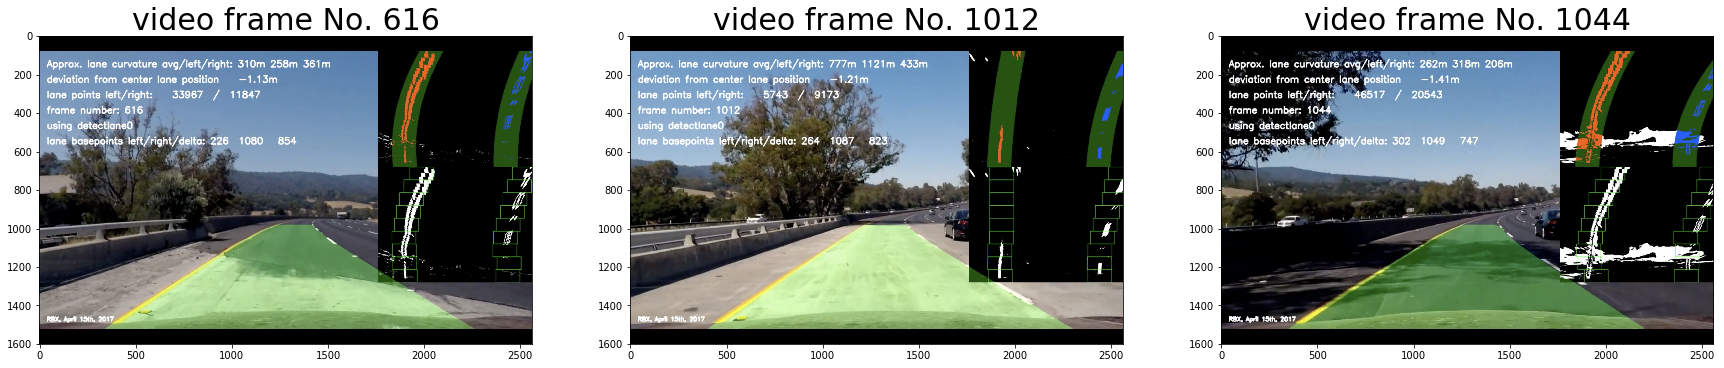

In [149]:
from PIL import Image
img1 = Image.open("output_images/videoframe0616.jpg")
img2 = Image.open('output_images/videoframe1012.jpg')
img3 = Image.open('output_images/videoframe1044.jpg')
#img1 = cv2.imread('output_images/videoframe0616.jpg')
#img2 = cv2.imread('output_images/videoframe1012.jpg')
#img3 = cv2.imread('output_images/videoframe1044.jpg')

# Visualize undistortion
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,20))
ax1.imshow(img1)
ax1.set_title('video frame No. 616', fontsize=30)
ax2.imshow(img2)
ax2.set_title('video frame No. 1012', fontsize=30)
ax3.imshow(img3)
ax3.set_title('video frame No. 1044', fontsize=30)

#### What could you do to make it more robust?

Due to lack of time I could not fix what I planned to do.

A main feature that should be included is to make use of the already build in class for the lanes. That is the base for doing an average over the lanes points already detected in previous frames. This is mainly important when a shadow or high / intense light (direct sun light) situation comes into play. In that case the frame will not result in a valid lane detection so it is necessary to take previous frames as base for averaging lane points and discard the current frame to still receive a valid lane detection.

One further drawback is using a polynomal fit and not a spline which could take advantage of much more accurate representation of the lanes.

A further improvement could be using the base points of lane width as some sort of moving frame for representing the lane. e.g. lane width should be always equal on bottom and top of the video frame. This can be used for improving in case of visual disturbances.

Finally the size of the wa<rped image should be extented further to avoid a dropping out of the search window out of the right side (or in some cases left as well) of the video frame. That currently results in missing poiunts at the very top of the lane, especially at the end of the video.